# Greenland peripheral glacier automated terminus detection image download and pre-processing

By Jukes Liu (jukes.liu@boisestate.edu)

_Last modified 05-07-2020._

# 1) Set-up: import necessary packages, set paths, and glaciers of interest

In [2]:
import numpy as np
import pandas as pd
import scipy
import math

import subprocess
import os
import shutil

from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#geospatial packages
import fiona
import geopandas as gpd
from shapely.geometry import Polygon, Point
import shapely
import rasterio

# Enable fiona KML file reading driver
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

#Set base paths
basepath='/home/jukes/Documents/Sample_glaciers/' # folder containing the box shapefile and info
downloadpath = '/media/jukes/jukes1/LS8aws/' # folder to contain the downloaded images

# import necessary functions from automated-glacier-terminus.py
os.chdir('/home/jukes/automated-glacier-terminus') #import necessary functions:
from automated_terminus_functions import distance

In [16]:
import sys
!{sys.executable} -m pip install opencv-python

     |████████████████████████████████| 28.2 MB 12.4 MB/s eta 0:00:01


#### Enter glaciers of interest by their 3-digit BoxIDs

In [3]:
BoxIDs = np.arange(101, 301, 5)
# BoxIDs = np.arange(100, 300, 5)
BoxIDs = list(map(str, BoxIDs))
BoxIDs.remove('141');
print(BoxIDs)

['101', '106', '111', '116', '121', '126', '131', '136', '146', '151', '156', '161', '166', '171', '176', '181', '186', '191', '196', '201', '206', '211', '216', '221', '226', '231', '236', '241', '246', '251', '256', '261', '266', '271', '276', '281', '286', '291', '296']


#### Create new folders corresponding to these glaciers

In [84]:
# create new BoxID folders 
for BoxID in BoxIDs:
    # create folder in Sample_glaciers
    if os.path.exists(basepath+'Box'+BoxID)==True:
#         shutil.rmtree(basepath+'Box'+BoxID)
        print("Path exists already in Sample_glaciers for Box", BoxID)
    else:
        os.mkdir(basepath+'Box'+BoxID)
        
    # move terminus box shapefile into the new folder
    ID = int(BoxID) # make into an integer in order to grab the .shp files from Boxes_individual
    boxespath = '/media/jukes/jukes1/Boxes_individual/'
    for file in os.listdir(boxespath):
        if file.startswith(str(ID)):
            if len(file) == len(str(ID))+4:
#             if file.endswith('.dbf') or file.endswith('.prj') or file.endswith('.qpj') or file.endswith('.shx') or file.endswith('.shp'):
                shutil.copyfile(boxespath+file, basepath+'Box'+BoxID+'/Box'+BoxID+file[-4:])

    # move RGI glacier outline into the new folder
    RGIpath = '/media/jukes/jukes1/RGI_shps/'
    for file in os.listdir(RGIpath):
        if file.startswith('BoxID_'+str(ID)):
            shutil.copyfile(RGIpath+file, basepath+'Box'+BoxID+'/RGI_Box'+BoxID+file[-4:])
            
    # make new download path folder
    if os.path.exists(downloadpath+'/Box'+BoxID)==True:
        print("Path exists already in LS8aws for Box", BoxID)
    else:
        os.mkdir(downloadpath+'/Box'+BoxID)

Path exists already in Sample_glaciers for Box 100
Path exists already in LS8aws for Box 100
Path exists already in Sample_glaciers for Box 105
Path exists already in LS8aws for Box 105
Path exists already in Sample_glaciers for Box 110
Path exists already in LS8aws for Box 110
Path exists already in Sample_glaciers for Box 115
Path exists already in LS8aws for Box 115
Path exists already in Sample_glaciers for Box 120
Path exists already in LS8aws for Box 120
Path exists already in Sample_glaciers for Box 125
Path exists already in LS8aws for Box 125
Path exists already in Sample_glaciers for Box 130
Path exists already in LS8aws for Box 130
Path exists already in Sample_glaciers for Box 135
Path exists already in LS8aws for Box 135
Path exists already in Sample_glaciers for Box 140
Path exists already in LS8aws for Box 140
Path exists already in Sample_glaciers for Box 145
Path exists already in LS8aws for Box 145
Path exists already in Sample_glaciers for Box 150
Path exists already

# 2) Find all the Landsat Path Row identifiers that overlap the glaciers

This step requires the WRS-2_bound_world.kml file containing the footprints of all the Landsat scene boundaries available through the USGS (https://www.usgs.gov/land-resources/nli/landsat/landsat-shapefiles-and-kml-files). To check if they overlap the glacier terminus box shapefiles, the box shapefiles must be reprojected into WRS84 coordinates (ESPG: 4326) using GDAL command line command:

    ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:NEW_EPSG_NUMBER -s_srs EPSG:OLD_EPSG_NUMBER output.shp input.shp

In [41]:
# reproject
for BoxID in BoxIDs:
    boxpath = basepath+"Box"+BoxID+"/Box"+BoxID
            
    rp = "ogr2ogr --config GDAL_DATA /usr/share/gdal/ -f 'ESRI Shapefile' -t_srs EPSG:4326 -s_srs EPSG:3413 "+boxpath+"_WRS.shp "+boxpath+".shp"
    subprocess.call(rp, shell=True)
    print(BoxID)

101
106
111
116
121
126
131
136
141
146
151
156
161
166
171
176
181
186
191
196
201
206
211
216
221
226
231
236
241
246
251
256
261
266
271
276
281
286
291
296


In [17]:
# Grab the boxes' WRS84 coordinates
box_points = {}
for BoxID in BoxIDs:
    boxpath = basepath+"Box"+BoxID+"/Box"+BoxID; termbox = fiona.open(boxpath+'_WRS.shp')
    box = termbox.next()
    box_geom= box.get('geometry'); box_coords = box_geom.get('coordinates')[0]  
    points = [] # to hold the vertices
    for coord_pair in box_coords:
        lat = coord_pair[0]; lon = coord_pair[1]
        #create shapely pyoints and append to points list
        point = shapely.geometry.Point(lat, lon)
#         print(point)
        points.append(point)
    box_points.update({BoxID: points}); print("Box"+BoxID)

Box101
Box106
Box111
Box116
Box121
Box126
Box131
Box136
Box141
Box146
Box151
Box156
Box161
Box166
Box171
Box176
Box181
Box186
Box191
Box196
Box201
Box206
Box211
Box216
Box221
Box226
Box231
Box236
Box241
Box246
Box251
Box256
Box261
Box266
Box271
Box276
Box281
Box286
Box291
Box296


/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  """


In [18]:
#open the kml file with the pathrow bounds as WRS
WRS = fiona.open(basepath+'WRS-2_bound_world.kml', driver='KML')

### Loop through all the scene footprints and stores those that overlap ALL of your shapefile vertices:

In [36]:
#create lists to hold the paths and rows and BoxIDs
paths = []; rows = []; boxes = []

#loop through all features in the WRS .kml:
for feature in WRS:
    #create shapely polygons with the pathrow bounds
    coordinates = feature['geometry']['coordinates'][0]
    coords = [xy[0:2] for xy in coordinates]
#     print(coords)
    pathrow_poly = Polygon(coords)
    #grab the path and row name
    pathrowname = feature['properties']['Name']  
    path = pathrowname.split('_')[0]; row = pathrowname.split('_')[1]
#     print(path, row)
    
    #for each feature, loop through each of the box_points
    for BoxID in box_points:
        #create a counter for number of box_points in the pathrow_geom:
        box_points_in = 0
        
        points = box_points.get(BoxID)
        for i in range(0, len(points)):
            point = points[i]
            #if the pathrow shape contains the point
            if point.within(pathrow_poly):
#                 print("Found")
                #append the counter
                box_points_in = box_points_in+1
#         print(box_points_in)
        if box_points_in == 5:
            #save that path row and boxID
            paths.append('%03d' % int(path)); rows.append('%03d' % int(row))
            boxes.append(BoxID)

boxes_pr_df = pd.DataFrame(list(zip(boxes, paths, rows)), columns=['BoxID','Path', 'Row'])
boxes_pr_df = boxes_pr_df.sort_values(by='BoxID')
boxes_pr_df

,BoxID,Path,Row
0,101,233,018
2,101,232,018
8,101,233,017
1,106,233,018
3,106,232,018
...,...,...,...
108,291,232,013
103,296,231,014
106,296,230,014
109,296,232,013


#### Write it to a csv file:

In [37]:
PR_FILENAME = 'LS_pathrows_SE_2.csv'
boxes_pr_df.to_csv(path_or_buf = basepath+PR_FILENAME, sep=',')

# 3) Download metadata (MTL.txt) files for all available images over glaciers

Bulk download Landsat-8 images and metadata stored on the Amazon Web Services cloud (s3 bucket) over a region of interest using the Amazon Web Services command line interface. Follow instructions at https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-install.html to get aws commands onto your command terminal. The syntax for grabbing an individual metadata file is as follows:

     aws --no-sign-request s3 cp s3://landsat-pds/L8/path/row/LC8pathrowyear001LGN00/LC8pathrowyear001LGN00_MTL.txt /path_to/output/

Access https://docs.opendata.aws/landsat-pds/readme.html to learn more.

#### Download the metadatafiles into Path_Row folders created using:

    aws --no-sign-request s3 cp s3://landsat-pds/L8/031/005/ Output/path/LS8aws/Path031_Row005/ --recursive --exclude "*" --include "*.txt" 

In [102]:
boxes_pr_df  =pd.read_csv(basepath+PR_FILENAME, usecols=[1,2,3], dtype=str)
boxes_pr_df = boxes_pr_df.set_index('BoxID'); boxes_pr_df

,Path,Row
BoxID,,
101,233,018
101,232,018
101,233,017
106,233,018
106,232,018
...,...,...
291,232,013
296,231,014
296,230,014


In [98]:
#Loop through the dataframe with your path row combinations:
for index, row in boxes_pr_df.iterrows():
    #grab the path row names and set the folder name
    path = row['Path']; row = row['Row']; folder_name = 'Path'+path+'_Row'+row

    #set path to access the image on the amazon cloud:
    bp_in = 's3://landsat-pds/L8/'; totalp_in = bp_in+path+'/'+row+'/'
    #set output path for the downloaded files:
    bp_out = downloadpath+'/'+folder_name+'/'; print(bp_out)
    
    #create Path_Row folders and do the download if they don't exist already to hold the metadata
    if os.path.exists(bp_out):
        print(folder_name, " EXISTS ALREADY. SKIP.")
    else:
        os.mkdir(bp_out)
        print(folder_name+" directory made")

        command = 'aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*.txt"'
        print(command)

        #call the command line that downloads the metadata files using aws
        subprocess.call(command, shell=True)

/media/jukes/jukes1/LS8aws//Path233_Row018/
Path233_Row018  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path232_Row018/
Path232_Row018  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path233_Row017/
Path233_Row017  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path233_Row018/
Path233_Row018  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path232_Row018/
Path232_Row018  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path233_Row017/
Path233_Row017  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path232_Row018/
Path232_Row018  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path233_Row017/
Path233_Row017  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path233_Row017/
Path233_Row017  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path232_Row018/
Path232_Row018  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path232_Row018/
Path232_Row018  EXISTS ALREADY. SKIP.
/media/jukes/jukes1/LS8aws//Path233_Row017/
Path233_Row017  EXISTS ALREADY. SKIP.
/media/jukes/juk

# 4) Determine how cloudy the images are using the LS quality band files subset to terminus box

Use gdalwarp commands and the __vsicurl__ link to download subset of the quality band we will use to determine cloud cover:

    gdalwarp -cutline path_to_shp.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/031/005/LC80310052013143LGN01/LC80310052013143LGN01_BQA.TIF path_to_subsetBQA.TIF
    
These will need to go into the newly created BoxID folders because the subset of the same image for different boxes will be different. We will need to reproject the shapefiles into UTM to match the LS8 bands. We must grab the UTM zones from the metadata files downloaded and fill in the following syntax:
    
    ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:326zone -s_srs EPSG:3413 output.shp input.shp

In [122]:
zones = {}; zone_df = []

#Loop through the dataframe with your path row combinations:
for index, row in boxes_pr_df.iterrows():
    path = row['Path']; row = row['Row']; BoxID = str(index); folder_name = 'Path'+path+'_Row'+row
    
    #set path to path row folders to grab scenes from and output path according to each of the BoxIDs
    pr_folderpath = downloadpath+'/'+folder_name+'/'
    
    #set shapefile path for each BoxID
    pathtoshp = basepath+"Box"+BoxID+"/Box"+BoxID
    
    #if there are files in the folder:
    if len(os.listdir(pr_folderpath)) > 0:
        #grab UTM Zone from the first metadata file in the pr_folderpath
        mtl_scene = os.listdir(pr_folderpath)[0]
        mtl = open(pr_folderpath+mtl_scene+'/'+mtl_scene+'_MTL.txt', 'r')
        
        #loop through each line in metadata to find the UTM ZONE
        for line in mtl:
            variable = line.split("=")[0]
            if ("UTM_ZONE" in variable): 
                #save it:
                zone = '%02d' % int(line.split("=")[1][1:-1])
                zones.update({folder_name: zone}); zone_df.append(zone)
                
        #reproject shapefile(s) into UTM
        zone = zones[folder_name]
        rp_shp = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:326'+zone+' -s_srs EPSG:4326 '+pathtoshp+"_UTM_"+zone+".shp "+pathtoshp+"_WRS.shp"
        subprocess.call(rp_shp, shell=True)
    #if not, append nan to zone and do nothing
    else:
        zone_df.append(np.nan)
        
    #grab the names of the LS8 scenes from the downloaded metadatafiles using os.listdir() in the Path_Row folders
    scenes = os.listdir(pr_folderpath)

    for scene in scenes:
        #if the file grabbed does correspond to a Landsat scene (contains LGN as the 5th -3rd from last letters):
        if len(scenes) > 0 and scene.endswith("LGN", -5, -2):            
            #set path to reprojected box shp
            pathtoshp_rp = pathtoshp+'_UTM_'+zones[folder_name]
            
            #set path to the quality band (BQA.TIF) in the cloud using the scenename
            pathtoBQA = '/vsicurl/https://landsat-pds.s3.amazonaws.com/L8/'+path+'/'+row+'/'+scene+"/"+scene+"_BQA.TIF"
            subsetout = pr_folderpath+scene+"/"+scene+'_BQA_Box'+BoxID+'.TIF'

            #Check download command syntax
            BQA_dwnld_cmd = 'gdalwarp -cutline '+pathtoshp_rp+'.shp -crop_to_cutline '+pathtoBQA+' '+subsetout

            #When you've checked everything, uncomment the following to run:
            subprocess.call(BQA_dwnld_cmd, shell=True)
            print(scene+'_BQA_Box'+BoxID+'.TIF subset downloaded')

boxes_pr_df['Zone'] = zone_df
print("Done.")

Done.


#### Re-save csv file with the zone information

In [124]:
PR_FILENAME = 'LS_pathrows_SE_2.csv'
boxes_pr_df.to_csv(path_or_buf = basepath+PR_FILENAME, sep=',')

# 5) Create buffer zone around terminus boxes and rasterize/subset terminus boxes (used for cropping and masknig later on)

The following code pulls the buffer distances around the terminus boxes from an existing .csv file with the exported attributes tables for the peripheral glacier terminus boxes. These buffer distances will be used to create a buffer zone to subset the Landsat scenes.

In [107]:
buffers = []
#Calculate a buffer distance around the terminus box using the UTM projected boxes
for BoxID in BoxIDs:
    buff_distances = []

    for file in os.listdir(basepath+'Box'+BoxID+'/'):
        if 'UTM' in file and '.shp' in file and "Box" in file:
            print(file)
            boxpath = basepath+"Box"+BoxID+"/"+file  
            termbox = fiona.open(boxpath)
            #grab the box feature:
            box = termbox.next(); box_geom= box.get('geometry'); box_coords = box_geom.get('coordinates')[0]
            points = []
            for coord_pair in box_coords:
                lat = coord_pair[0]; lon = coord_pair[1]; points.append([lat, lon])
            
            #Calculate distance between 1 and 2 and distance between 2 and 3 and pick the longer one
            coord1 = points[0]; coord2 = points[1]; coord3 = points[2]   
            dist1 = distance(coord1[0], coord1[1], coord2[0], coord2[1]);
            dist2 = distance(coord2[0], coord2[1], coord3[0], coord3[1])  
            buff_dist = int(np.max([dist1, dist2]))
            buff_distances.append(buff_dist) 
    buffer = buff_distances[0]; buffers.append(buffer)
buff_df = pd.DataFrame(list(zip(BoxIDs, buffers)), columns=['BoxID', 'Buff_dist_m'])
buff_df

Box101_UTM_23.shp
Box106_UTM_23.shp
Box111_UTM_23.shp
Box116_UTM_23.shp
Box121_UTM_23.shp
Box121_UTM_24.shp
Box126_UTM_23.shp
Box126_UTM_24.shp
Box131_UTM_23.shp
Box131_UTM_24.shp
Box136_UTM_23.shp
Box136_UTM_24.shp
Box146_UTM_23.shp
Box146_UTM_24.shp
Box151_UTM_24.shp
Box151_UTM_23.shp
Box156_UTM_23.shp
Box156_UTM_24.shp
Box161_UTM_24.shp
Box161_UTM_23.shp
Box166_UTM_23.shp
Box166_UTM_24.shp
Box171_UTM_24.shp
Box171_UTM_23.shp
Box176_UTM_23.shp
Box176_UTM_24.shp
Box181_UTM_24.shp
Box181_UTM_23.shp
Box186_UTM_23.shp
Box186_UTM_24.shp
Box191_UTM_24.shp
Box191_UTM_23.shp
Box196_UTM_23.shp
Box196_UTM_24.shp
Box201_UTM_23.shp
Box201_UTM_24.shp
Box206_UTM_23.shp
Box206_UTM_24.shp
Box211_UTM_24.shp
Box211_UTM_23.shp
Box216_UTM_24.shp
Box216_UTM_23.shp
Box221_UTM_24.shp
Box226_UTM_23.shp
Box226_UTM_24.shp
Box231_UTM_23.shp
Box231_UTM_24.shp
Box236_UTM_24.shp
Box241_UTM_24.shp
Box246_UTM_24.shp
Box251_UTM_24.shp
Box256_UTM_23.shp
Box256_UTM_24.shp
Box261_UTM_23.shp
Box261_UTM_24.shp
Box266_UTM

/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  if sys.path[0] == '':


,BoxID,Buff_dist_m
0,101,1652
1,106,727
2,111,847
3,116,1561
4,121,1352
5,126,1210
6,131,1716
7,136,954
8,146,1346
9,151,1087


The next section creates a buffer zone shapefile using GDAL command **ogr2ogr** with the following syntax:

    ogr2ogr Buffer###.shp path_to_terminusbox###.shp  -dialect sqlite -sql "SELECT ST_Buffer(geometry, buffer_distance) AS geometry,*FROM 'Box###'" -f "ESRI Shapefile"

In [108]:
for index, row in buff_df.iterrows():
    BoxID = row['BoxID']
    buff_dist = str(row['Buff_dist_m'])
    
    #SET path to the terminus box shapefiles
    terminusbox_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"
    outputbuffer_path = basepath+"Box"+BoxID+"/Buffer"+BoxID+".shp"
    
    #SET buffer command and print to check it
    buffer_cmd = 'ogr2ogr '+outputbuffer_path+" "+terminusbox_path+' -dialect sqlite -sql "SELECT ST_Buffer(geometry, '+buff_dist+") AS geometry,*FROM 'Box"+BoxID+"'"+'" -f "ESRI Shapefile"'
    print(buffer_cmd)
    
    subprocess.call(buffer_cmd, shell=True) 
    print("Box"+BoxID)

ogr2ogr /home/jukes/Documents/Sample_glaciers/Box101/Buffer101.shp /home/jukes/Documents/Sample_glaciers/Box101/Box101.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1652) AS geometry,*FROM 'Box101'" -f "ESRI Shapefile"
Box101
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box106/Buffer106.shp /home/jukes/Documents/Sample_glaciers/Box106/Box106.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 727) AS geometry,*FROM 'Box106'" -f "ESRI Shapefile"
Box106
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box111/Buffer111.shp /home/jukes/Documents/Sample_glaciers/Box111/Box111.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 847) AS geometry,*FROM 'Box111'" -f "ESRI Shapefile"
Box111
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box116/Buffer116.shp /home/jukes/Documents/Sample_glaciers/Box116/Box116.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1561) AS geometry,*FROM 'Box116'" -f "ESRI Shapefile"
Box116
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box121/Buffer121.shp /ho

Box286
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box291/Buffer291.shp /home/jukes/Documents/Sample_glaciers/Box291/Box291.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1942) AS geometry,*FROM 'Box291'" -f "ESRI Shapefile"
Box291
ogr2ogr /home/jukes/Documents/Sample_glaciers/Box296/Buffer296.shp /home/jukes/Documents/Sample_glaciers/Box296/Box296.shp -dialect sqlite -sql "SELECT ST_Buffer(geometry, 1291) AS geometry,*FROM 'Box296'" -f "ESRI Shapefile"
Box296


The terminus box shapefiles are then rasterized (to be used as a mask during the WTMM filering) using the GDAL **gdal_rasterize** command and subset to the buffer zone using the GDAL **gdalwarp** command using the following syntax:

1) Rasterize

    gdal_rasterize -burn 1.0 -tr x_resolution y_resolution -a_nodata 0.0 path_to_terminusbox.shp path_to_terminusbox_raster.TIF

The x_resolution and y_resolution are set to be 15.0 (meters) to match the Landsat B8 resolution.
    
2) Subset

    gdalwarp -cutline path_to_Buffer###.shp -crop_to_cutline path_to_terminusbox_raster.TIF path_to_subset_raster_cut.TIF

In [109]:
for index, row in buff_df.iterrows():
    BoxID = row['BoxID']
    #SET path to the terminus box shapefiles
    terminusbox_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"
    buffer_path = basepath+"Box"+BoxID+"/Buffer"+BoxID+".shp"
    
    #output raster path:
    terminusraster_path = basepath+"Box"+BoxID+"/Box"+BoxID+".TIF"
    cutraster_path = basepath+"Box"+BoxID+"/Box"+BoxID+"_raster_cut.TIF"
    
    #SET commands and print to check
    rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 '+terminusbox_path+' '+terminusraster_path
    subsetbuffer_cmd = 'gdalwarp -cutline '+buffer_path+' -crop_to_cutline '+terminusraster_path+" "+cutraster_path
    
    #RASTERIZE & SUBSET
    subprocess.call(rasterize_cmd, shell=True)
    subprocess.call(subsetbuffer_cmd, shell=True)
    
    print("Box"+BoxID)

Box101
Box106
Box111
Box116
Box121
Box126
Box131
Box136
Box146
Box151
Box156
Box161
Box166
Box171
Box176
Box181
Box186
Box191
Box196
Box201
Box206
Box211
Box216
Box221
Box226
Box231
Box236
Box241
Box246
Box251
Box256
Box261
Box266
Box271
Box276
Box281
Box286
Box291
Box296


# 6) Download non-cloudy images

To threshold out cloudy images, we will find the number of pixels in our shapefile region that correspond to a cumulative pixel value of > __25000__. If the number of pixels with values above this threshold is greater than our % threshold, we won't download the image. 

__EDITED: We'll also filter out those images along the border that cutoff through your shapefile region. These will have a designated fill value of 1.__

Set cloudy and fill thresholds:

In [87]:
#SET cloud cover threshold
cpercent_thresh = 20.0

#SET fill percent threshold
fpercent_thresh = 60.0

#SET BQA pixel value threshold
BQA_thresh = 25000.0

Set LS bands to download:

In [90]:
#SET your desired bands here
bands = [10, 11]
# bands = [2, 3, 4]

### Download the images that pass these thresholds:

In [91]:
#Loop through the dataframe with your path row combinations:
for index, row in boxes_pr_df.iterrows():
    #grab the path row names and set the folder name
    path = row['Path']; zone = row['Zone']; row = row['Row']; BoxID = index; 
    folder_name = 'Path'+path+'_Row'+row
    
    #set path to path row folders to grab BQA files from
    pr_folderpath = downloadpath+'/'+folder_name+'/'
    
    #Output BoxID folderpath and create BoxID folders
    bp_out = downloadpath+'Box'+BoxID+'/'
    
    if os.path.exists(bp_out):
        print("Box"+BoxID, " EXISTS ALREADY. SKIP.")
    else:
        os.mkdir(bp_out)
        print("Box"+BoxID+" directory made")
                      
    #set path to the buffer zones for final subsetting:
    pathtobuffer = basepath+'Box'+BoxID+'/Buffer'+BoxID
#     pathtoshp_rp = basepath+'Box'+BoxID+'/Box'+BoxID+'_UTM_'+zone+'.shp'
    
    #REPROJECT BUFFER SHAPE
    if len(os.listdir(pr_folderpath)) > 0:
#         print(zone)
        rp_shp = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:326'+zone+' -s_srs EPSG:3413 '+pathtobuffer+"_UTM_"+zone+".shp "+pathtobuffer+".shp"
#         print(rp_shp)
        subprocess.call(rp_shp, shell=True)

    #loop through all the BQA files in the path_row folders:
    for scene in os.listdir(pr_folderpath):
        if len(os.listdir(pr_folderpath)) > 0 and scene.endswith("LGN", -5, -2):
            #grab all the BQA files to calculate the percent cloud
            BQApath = pr_folderpath+scene+"/"+scene+'_BQA_Box'+BoxID+'.TIF'
#             print(BQApath)
            
            #read in your BQA subset raster as a numpy array:
            subsetBQA = mpimg.imread(BQApath)
            
            #CALCULATE % CLOUD COVER USING YOUR BQA SUBSET
            #first, calculate the total number of pixels
            totalpixels = subsetBQA.shape[0]*subsetBQA.shape[1]
            
            #then, calculate the number of cloud pixels:
            #mask for pixels that have a value > than your threshold value
            cloudBQA = subsetBQA[subsetBQA > BQA_thresh]
            
            #calculate number of fill pixels (fill value of 1. Will be less than 2.0)
            fillBQA = subsetBQA[subsetBQA < 2.0]
            
            #and count those cloudpixels and fillpixels:
            cloudpixels = len(cloudBQA); fillpixels = len(fillBQA)
            
            #divide this by the totalpixels and multiply by 100
            cloudpercent = int(float(cloudpixels)/float(totalpixels)*100)
            fillpercent = int(float(fillpixels)/float(totalpixels)*100)
            
            #check that the values are sensible
            print(scene, 'Cloud % ', cloudpercent, 'Fill %', fillpercent)
            
            #set path to rp buffer:
            pathtobuffer_rp = pathtobuffer+"_UTM_"+zone+".shp"
            
            #IF % CLOUD COVER IS LESS THAN OR EQUAL TO YOUR THRESHOLD DOWNLOAD THE BANDS FOR THAT SCENE:
            if cloudpercent <= cpercent_thresh and fillpercent <= fpercent_thresh:
                #download the bands for that scene into your scene folders:
                for band in bands:
                    #make sure the band is in string format:
                    band = str(band)
                    #set input path to your bands in AWS:
                    pathin = '/vsicurl/https://landsat-pds.s3.amazonaws.com/L8/'+path+"/"+row+"/"+scene+"/"+scene+"_B"+band+".TIF"
                    #set your output path to the overall BoxID folder, not the scene folders
                    pathout = downloadpath+'Box'+BoxID+'/'+scene+"_B"+band+'_Buffer'+BoxID+'.TIF'
                    
                    #set download command and check:
                    download_cmd = 'gdalwarp -cutline '+pathtobuffer_rp+' -crop_to_cutline '+pathin+' '+pathout
#                     download_cmd = 'gdalwarp -cutline '+pathtoshp_rp+' -crop_to_cutline '+pathin+' '+pathout
                    print(download_cmd)
                    
                    #When you're ready, comment out the above print command and
                    #uncomment the following to commence the download:                   
                    subprocess.call(download_cmd, shell=True)
                    print(scene+"_B"+band+'_Buffer'+BoxID+".TIF downloaded")

Box101  EXISTS ALREADY. SKIP.
LC82330182016047LGN00 Cloud %  3 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182016047LGN00/LC82330182016047LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330182016047LGN00_B10_Buffer101.TIF
LC82330182016047LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182016047LGN00/LC82330182016047LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330182016047LGN00_B11_Buffer101.TIF
LC82330182016047LGN00_B11_Buffer101.TIF downloaded
LC82330182015236LGN00 Cloud %  11 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182015236LGN00/LC82330182015236LGN00_B10.TIF /me

LC82330182013294LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182013294LGN00/LC82330182013294LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330182013294LGN00_B11_Buffer101.TIF
LC82330182013294LGN00_B11_Buffer101.TIF downloaded
LC82330182017049LGN00 Cloud %  72 Fill % 27
LC82330182015012LGN00 Cloud %  72 Fill % 27
LC82330182013118LGN01 Cloud %  72 Fill % 27
LC82330182016191LGN00 Cloud %  72 Fill % 27
LC82330182013230LGN00 Cloud %  3 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182013230LGN00/LC82330182013230LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330182013230LGN00_B10_Buffer101.TIF
LC82330182013230LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box1

LC82330182016127LGN00_B11_Buffer101.TIF downloaded
LC82330182013150LGN00 Cloud %  4 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182013150LGN00/LC82330182013150LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330182013150LGN00_B10_Buffer101.TIF
LC82330182013150LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182013150LGN00/LC82330182013150LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330182013150LGN00_B11_Buffer101.TIF
LC82330182013150LGN00_B11_Buffer101.TIF downloaded
LC82330182015044LGN00 Cloud %  72 Fill % 27
LC82330182017113LGN00 Cloud %  72 Fill % 27
LC82330182015300LGN00 Cloud %  0 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsi

LC82330182017017LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182017017LGN00/LC82330182017017LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330182017017LGN00_B11_Buffer101.TIF
LC82330182017017LGN00_B11_Buffer101.TIF downloaded
LC82330182015348LGN00 Cloud %  0 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182015348LGN00/LC82330182015348LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330182015348LGN00_B10_Buffer101.TIF
LC82330182015348LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182015348LGN00/LC82330182015348LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320182015341LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015341LGN00/LC82320182015341LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82320182015341LGN00_B11_Buffer101.TIF
LC82320182015341LGN00_B11_Buffer101.TIF downloaded
LC82320182015149LGN00 Cloud %  12 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015149LGN00/LC82320182015149LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82320182015149LGN00_B10_Buffer101.TIF
LC82320182015149LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015149LGN00/LC82320182015149LGN00_B11.TIF /media/jukes/jukes1/LS8aw

LC82320182015277LGN00_B11_Buffer101.TIF downloaded
LC82320182014066LGN00 Cloud %  14 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014066LGN00/LC82320182014066LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82320182014066LGN00_B10_Buffer101.TIF
LC82320182014066LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014066LGN00/LC82320182014066LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82320182014066LGN00_B11_Buffer101.TIF
LC82320182014066LGN00_B11_Buffer101.TIF downloaded
LC82320182015181LGN00 Cloud %  4 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015181LGN00/LC8232018201

LC82320182016328LGN00_B11_Buffer101.TIF downloaded
LC82320182015069LGN00 Cloud %  3 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015069LGN00/LC82320182015069LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82320182015069LGN00_B10_Buffer101.TIF
LC82320182015069LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015069LGN00/LC82320182015069LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82320182015069LGN00_B11_Buffer101.TIF
LC82320182015069LGN00_B11_Buffer101.TIF downloaded
LC82320182013255LGN00 Cloud %  2 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182013255LGN00/LC82320182013

LC82320182015357LGN00_B11_Buffer101.TIF downloaded
LC82320182016360LGN00 Cloud %  0 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182016360LGN00/LC82320182016360LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82320182016360LGN00_B10_Buffer101.TIF
LC82320182016360LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182016360LGN00/LC82320182016360LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82320182016360LGN00_B11_Buffer101.TIF
LC82320182016360LGN00_B11_Buffer101.TIF downloaded
LC82320182015229LGN00 Cloud %  72 Fill % 27
LC82320182017042LGN00 Cloud %  72 Fill % 27
Box101  EXISTS ALREADY. SKIP.
LC82330172014201LGN00 Cloud %  44 Fill % 27
LC82330172013326LGN00 Cloud %  72 Fill % 27
LC82330172016047LGN00 Cloud % 

LC82330172015172LGN00_B11_Buffer101.TIF downloaded
LC82330172014249LGN00 Cloud %  3 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014249LGN00/LC82330172014249LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330172014249LGN00_B10_Buffer101.TIF
LC82330172014249LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014249LGN00/LC82330172014249LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330172014249LGN00_B11_Buffer101.TIF
LC82330172014249LGN00_B11_Buffer101.TIF downloaded
LC82330172014169LGN00 Cloud %  72 Fill % 27
LC82330172015268LGN00 Cloud %  8 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8

LC82330172016335LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016335LGN00/LC82330172016335LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330172016335LGN00_B11_Buffer101.TIF
LC82330172016335LGN00_B11_Buffer101.TIF downloaded
LC82330172015204LGN00 Cloud %  4 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015204LGN00/LC82330172015204LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330172015204LGN00_B10_Buffer101.TIF
LC82330172015204LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015204LGN00/LC82330172015204LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330172015028LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015028LGN00/LC82330172015028LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330172015028LGN00_B11_Buffer101.TIF
LC82330172015028LGN00_B11_Buffer101.TIF downloaded
LC82330172016319LGN00 Cloud %  46 Fill % 27
LC82330172015348LGN00 Cloud %  0 Fill % 27
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015348LGN00/LC82330172015348LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box101/LC82330172015348LGN00_B10_Buffer101.TIF
LC82330172015348LGN00_B10_Buffer101.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box101/Buffer101_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015348LGN00/LC8233017201

LC82330182015364LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182015364LGN00/LC82330182015364LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330182015364LGN00_B11_Buffer106.TIF
LC82330182015364LGN00_B11_Buffer106.TIF downloaded
LC82330182014153LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182014153LGN00/LC82330182014153LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330182014153LGN00_B10_Buffer106.TIF
LC82330182014153LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182014153LGN00/LC82330182014153LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330182016287LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182016287LGN00/LC82330182016287LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330182016287LGN00_B11_Buffer106.TIF
LC82330182016287LGN00_B11_Buffer106.TIF downloaded
LC82330182015092LGN00 Cloud %  59 Fill % 40
LC82330182014313LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182014313LGN00/LC82330182014313LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330182014313LGN00_B10_Buffer106.TIF
LC82330182014313LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182014313LGN00/LC8233018201

LC82330182016111LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182016111LGN00/LC82330182016111LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330182016111LGN00_B11_Buffer106.TIF
LC82330182016111LGN00_B11_Buffer106.TIF downloaded
LC82330182015252LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182015252LGN00/LC82330182015252LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330182015252LGN00_B10_Buffer106.TIF
LC82330182015252LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182015252LGN00/LC82330182015252LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330182016335LGN00_B11_Buffer106.TIF downloaded
LC82330182015156LGN00 Cloud %  59 Fill % 40
LC82330182015188LGN00 Cloud %  59 Fill % 40
LC82330182016351LGN00 Cloud %  4 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182016351LGN00/LC82330182016351LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330182016351LGN00_B10_Buffer106.TIF
LC82330182016351LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/018/LC82330182016351LGN00/LC82330182016351LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330182016351LGN00_B11_Buffer106.TIF
LC82330182016351LGN00_B11_Buffer106.TIF downloaded
LC82330182014089LGN00 Cloud %  59 Fill % 40
LC82330182016239LGN00 Cloud %  59 Fill % 40
LC82330182016079LGN00 Cloud %  59 Fill % 40
LC82330182013246

LC82320182014178LGN00_B11_Buffer106.TIF downloaded
LC82320182014290LGN00 Cloud %  6 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014290LGN00/LC82320182014290LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82320182014290LGN00_B10_Buffer106.TIF
LC82320182014290LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014290LGN00/LC82320182014290LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82320182014290LGN00_B11_Buffer106.TIF
LC82320182014290LGN00_B11_Buffer106.TIF downloaded
LC82320182016136LGN00 Cloud %  59 Fill % 40
LC82320182016344LGN00 Cloud %  59 Fill % 40
LC82320182016184LGN00 Cloud %  56 Fill % 40
LC82320182015213LGN00 Cloud %  2 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box10

LC82320182015181LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015181LGN00/LC82320182015181LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82320182015181LGN00_B11_Buffer106.TIF
LC82320182015181LGN00_B11_Buffer106.TIF downloaded
LC82320182016232LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182016232LGN00/LC82320182016232LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82320182016232LGN00_B10_Buffer106.TIF
LC82320182016232LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182016232LGN00/LC82320182016232LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320182014130LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014130LGN00/LC82320182014130LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82320182014130LGN00_B11_Buffer106.TIF
LC82320182014130LGN00_B11_Buffer106.TIF downloaded
LC82320182016040LGN00 Cloud %  59 Fill % 40
LC82320182015117LGN00 Cloud %  6 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015117LGN00/LC82320182015117LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82320182015117LGN00_B10_Buffer106.TIF
LC82320182015117LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015117LGN00/LC8232018201

LC82330172017065LGN00_B11_Buffer106.TIF downloaded
LC82330172015316LGN00 Cloud %  3 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015316LGN00/LC82330172015316LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330172015316LGN00_B10_Buffer106.TIF
LC82330172015316LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015316LGN00/LC82330172015316LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330172015316LGN00_B11_Buffer106.TIF
LC82330172015316LGN00_B11_Buffer106.TIF downloaded
LC82330172015236LGN00 Cloud %  1 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015236LGN00/LC82330172015

LC82330172015252LGN00_B11_Buffer106.TIF downloaded
LC82330172013246LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013246LGN00/LC82330172013246LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330172013246LGN00_B10_Buffer106.TIF
LC82330172013246LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013246LGN00/LC82330172013246LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330172013246LGN00_B11_Buffer106.TIF
LC82330172013246LGN00_B11_Buffer106.TIF downloaded
LC82330172017113LGN00 Cloud %  59 Fill % 40
LC82330172014089LGN00 Cloud %  59 Fill % 40
LC82330172017097LGN00 Cloud %  52 Fill % 40
LC82330172014185LGN00 Cloud %  59 Fill % 40
LC82330172016287LGN00 Cloud %  1 Fill % 40
gdalwarp -cutline

LC82330172015204LGN00_B11_Buffer106.TIF downloaded
LC82330172016255LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016255LGN00/LC82330172016255LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330172016255LGN00_B10_Buffer106.TIF
LC82330172016255LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016255LGN00/LC82330172016255LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330172016255LGN00_B11_Buffer106.TIF
LC82330172016255LGN00_B11_Buffer106.TIF downloaded
LC82330172013150LGN00 Cloud %  8 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013150LGN00/LC82330172013

LC82330172016319LGN00_B11_Buffer106.TIF downloaded
LC82330172015348LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015348LGN00/LC82330172015348LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330172015348LGN00_B10_Buffer106.TIF
LC82330172015348LGN00_B10_Buffer106.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box106/Buffer106_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015348LGN00/LC82330172015348LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box106/LC82330172015348LGN00_B11_Buffer106.TIF
LC82330172015348LGN00_B11_Buffer106.TIF downloaded
LC82330172016095LGN00 Cloud %  59 Fill % 40
LC82330172014345LGN00 Cloud %  59 Fill % 40
LC82330172016223LGN00 Cloud %  59 Fill % 40
LC82330172014009LGN00 Cloud %  59 Fill % 40
LC82330172016175LGN00 Cloud %  56 Fill % 40
LC82330172015156

LC82320182016104LGN00_B11_Buffer111.TIF downloaded
LC82320182014114LGN00 Cloud %  32 Fill % 45
LC82320182015101LGN00 Cloud %  54 Fill % 45
LC82320182016280LGN00 Cloud %  8 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182016280LGN00/LC82320182016280LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box111/LC82320182016280LGN00_B10_Buffer111.TIF
LC82320182016280LGN00_B10_Buffer111.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182016280LGN00/LC82320182016280LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box111/LC82320182016280LGN00_B11_Buffer111.TIF
LC82320182016280LGN00_B11_Buffer111.TIF downloaded
LC82320182014226LGN00 Cloud %  54 Fill % 45
LC82320182016024LGN00 Cloud %  54 Fill % 45
LC82320182014178LGN00 Cloud %  6 Fill % 45
gdalwarp -cutline

LC82320182016200LGN00_B11_Buffer111.TIF downloaded
LC82320182015277LGN00 Cloud %  3 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015277LGN00/LC82320182015277LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box111/LC82320182015277LGN00_B10_Buffer111.TIF
LC82320182015277LGN00_B10_Buffer111.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015277LGN00/LC82320182015277LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box111/LC82320182015277LGN00_B11_Buffer111.TIF
LC82320182015277LGN00_B11_Buffer111.TIF downloaded
LC82320182014066LGN00 Cloud %  2 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014066LGN00/LC82320182014

LC82320182016328LGN00_B11_Buffer111.TIF downloaded
LC82320182015069LGN00 Cloud %  40 Fill % 45
LC82320182013255LGN00 Cloud %  2 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182013255LGN00/LC82320182013255LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box111/LC82320182013255LGN00_B10_Buffer111.TIF
LC82320182013255LGN00_B10_Buffer111.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182013255LGN00/LC82320182013255LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box111/LC82320182013255LGN00_B11_Buffer111.TIF
LC82320182013255LGN00_B11_Buffer111.TIF downloaded
LC82320182014130LGN00 Cloud %  3 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8

LC82330172014201LGN00_B11_Buffer111.TIF downloaded
LC82330172013326LGN00 Cloud %  54 Fill % 45
LC82330172016047LGN00 Cloud %  0 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016047LGN00/LC82330172016047LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box111/LC82330172016047LGN00_B10_Buffer111.TIF
LC82330172016047LGN00_B10_Buffer111.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016047LGN00/LC82330172016047LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box111/LC82330172016047LGN00_B11_Buffer111.TIF
LC82330172016047LGN00_B11_Buffer111.TIF downloaded
LC82330172015124LGN00 Cloud %  31 Fill % 45
LC82330172014105LGN00 Cloud %  54 Fill % 45
LC82330172017065LGN00 Cloud %  11 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box1

LC82330172015268LGN00_B11_Buffer111.TIF downloaded
LC82330172016015LGN00 Cloud %  0 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016015LGN00/LC82330172016015LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box111/LC82330172016015LGN00_B10_Buffer111.TIF
LC82330172016015LGN00_B10_Buffer111.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016015LGN00/LC82330172016015LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box111/LC82330172016015LGN00_B11_Buffer111.TIF
LC82330172016015LGN00_B11_Buffer111.TIF downloaded
LC82330172016239LGN00 Cloud %  54 Fill % 45
LC82330172015092LGN00 Cloud %  54 Fill % 45
LC82330172015060LGN00 Cloud %  54 Fill % 45
LC82330172015252LGN00 Cloud %  3 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box11

LC82330172013278LGN00_B11_Buffer111.TIF downloaded
LC82330172015044LGN00 Cloud %  54 Fill % 45
LC82330172016191LGN00 Cloud %  54 Fill % 45
LC82330172015140LGN00 Cloud %  3 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015140LGN00/LC82330172015140LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box111/LC82330172015140LGN00_B10_Buffer111.TIF
LC82330172015140LGN00_B10_Buffer111.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015140LGN00/LC82330172015140LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box111/LC82330172015140LGN00_B11_Buffer111.TIF
LC82330172015140LGN00_B11_Buffer111.TIF downloaded
LC82330172016335LGN00 Cloud %  20 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vs

LC82330172014217LGN00_B11_Buffer111.TIF downloaded
LC82330172014265LGN00 Cloud %  3 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014265LGN00/LC82330172014265LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box111/LC82330172014265LGN00_B10_Buffer111.TIF
LC82330172014265LGN00_B10_Buffer111.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014265LGN00/LC82330172014265LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box111/LC82330172014265LGN00_B11_Buffer111.TIF
LC82330172014265LGN00_B11_Buffer111.TIF downloaded
LC82330172016031LGN00 Cloud %  0 Fill % 45
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box111/Buffer111_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016031LGN00/LC82330172016

LC82330172015236LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015236LGN00/LC82330172015236LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box116/LC82330172015236LGN00_B11_Buffer116.TIF
LC82330172015236LGN00_B11_Buffer116.TIF downloaded
LC82330172013102LGN01 Cloud %  59 Fill % 39
LC82330172014233LGN00 Cloud %  0 Fill % 39
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014233LGN00/LC82330172014233LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box116/LC82330172014233LGN00_B10_Buffer116.TIF
LC82330172014233LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014233LGN00/LC8233017201

LC82330172015220LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015220LGN00/LC82330172015220LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box116/LC82330172015220LGN00_B11_Buffer116.TIF
LC82330172015220LGN00_B11_Buffer116.TIF downloaded
LC82330172016207LGN00 Cloud %  60 Fill % 39
LC82330172016271LGN00 Cloud %  0 Fill % 39
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016271LGN00/LC82330172016271LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box116/LC82330172016271LGN00_B10_Buffer116.TIF
LC82330172016271LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016271LGN00/LC8233017201

LC82330172013310LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013310LGN00/LC82330172013310LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box116/LC82330172013310LGN00_B11_Buffer116.TIF
LC82330172013310LGN00_B11_Buffer116.TIF downloaded
LC82330172014121LGN00 Cloud %  60 Fill % 39
LC82330172014137LGN00 Cloud %  0 Fill % 39
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC82330172014137LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box116/LC82330172014137LGN00_B10_Buffer116.TIF
LC82330172014137LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC8233017201

LC82320182017026LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182017026LGN00/LC82320182017026LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box116/LC82320182017026LGN00_B11_Buffer116.TIF
LC82320182017026LGN00_B11_Buffer116.TIF downloaded
LC82320182015005LGN00 Cloud %  0 Fill % 39
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015005LGN00/LC82320182015005LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box116/LC82320182015005LGN00_B10_Buffer116.TIF
LC82320182015005LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015005LGN00/LC82320182015005LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320182015165LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015165LGN00/LC82320182015165LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box116/LC82320182015165LGN00_B11_Buffer116.TIF
LC82320182015165LGN00_B11_Buffer116.TIF downloaded
LC82320182016008LGN00 Cloud %  45 Fill % 39
LC82320182016216LGN00 Cloud %  60 Fill % 39
LC82320182013335LGN00 Cloud %  2 Fill % 39
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182013335LGN00/LC82320182013335LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box116/LC82320182013335LGN00_B10_Buffer116.TIF
LC82320182013335LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC82320182015197LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015197LGN00/LC82320182015197LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box116/LC82320182015197LGN00_B11_Buffer116.TIF
LC82320182015197LGN00_B11_Buffer116.TIF downloaded
LC82320182015309LGN00 Cloud %  0 Fill % 39
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015309LGN00/LC82320182015309LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box116/LC82320182015309LGN00_B10_Buffer116.TIF
LC82320182015309LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015309LGN00/LC82320182015309LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320182014194LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014194LGN00/LC82320182014194LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box116/LC82320182014194LGN00_B11_Buffer116.TIF
LC82320182014194LGN00_B11_Buffer116.TIF downloaded
LC82320182015357LGN00 Cloud %  0 Fill % 39
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015357LGN00/LC82320182015357LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box116/LC82320182015357LGN00_B10_Buffer116.TIF
LC82320182015357LGN00_B10_Buffer116.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box116/Buffer116_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015357LGN00/LC82320182015357LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320182015213LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015213LGN00/LC82320182015213LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320182015213LGN00_B11_Buffer121.TIF
LC82320182015213LGN00_B11_Buffer121.TIF downloaded
LC82320182014146LGN00 Cloud %  2 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014146LGN00/LC82320182014146LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320182014146LGN00_B10_Buffer121.TIF
LC82320182014146LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182014146LGN00/LC82320182014146LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320182016312LGN00_B11_Buffer121.TIF downloaded
LC82320182015261LGN00 Cloud %  78 Fill % 21
LC82320182014082LGN00 Cloud %  56 Fill % 21
LC82320182013319LGN00 Cloud %  0 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182013319LGN00/LC82320182013319LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320182013319LGN00_B10_Buffer121.TIF
LC82320182013319LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182013319LGN00/LC82320182013319LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320182013319LGN00_B11_Buffer121.TIF
LC82320182013319LGN00_B11_Buffer121.TIF downloaded
LC82320182014050LGN01 Cloud %  78 Fill % 21
LC82320182016072LGN00 Cloud %  4 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box12

LC82320182013351LGN00_B11_Buffer121.TIF downloaded
LC82320182016264LGN00 Cloud %  51 Fill % 21
LC82320182014162LGN00 Cloud %  78 Fill % 21
LC82320182017010LGN00 Cloud %  78 Fill % 21
LC82320182015085LGN00 Cloud %  15 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015085LGN00/LC82320182015085LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320182015085LGN00_B10_Buffer121.TIF
LC82320182015085LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/018/LC82320182015085LGN00/LC82320182015085LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320182015085LGN00_B11_Buffer121.TIF
LC82320182015085LGN00_B11_Buffer121.TIF downloaded
LC82320182016152LGN00 Cloud %  48 Fill % 21
LC82320182017090LGN00 Cloud %  4 Fill % 21
gdalwarp -cutlin

LC82330172014329LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014329LGN00/LC82330172014329LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82330172014329LGN00_B11_Buffer121.TIF
LC82330172014329LGN00_B11_Buffer121.TIF downloaded
LC82330172017001LGN00 Cloud %  3 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017001LGN00/LC82330172017001LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82330172017001LGN00_B10_Buffer121.TIF
LC82330172017001LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017001LGN00/LC82330172017001LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330172016271LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016271LGN00/LC82330172016271LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82330172016271LGN00_B11_Buffer121.TIF
LC82330172016271LGN00_B11_Buffer121.TIF downloaded
LC82330172016303LGN00 Cloud %  2 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016303LGN00/LC82330172016303LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82330172016303LGN00_B10_Buffer121.TIF
LC82330172016303LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016303LGN00/LC82330172016303LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330172013310LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013310LGN00/LC82330172013310LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82330172013310LGN00_B11_Buffer121.TIF
LC82330172013310LGN00_B11_Buffer121.TIF downloaded
LC82330172014121LGN00 Cloud %  78 Fill % 21
LC82330172014137LGN00 Cloud %  1 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC82330172014137LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82330172014137LGN00_B10_Buffer121.TIF
LC82330172014137LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC8233017201

LC82330172017017LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017017LGN00/LC82330172017017LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82330172017017LGN00_B11_Buffer121.TIF
LC82330172017017LGN00_B11_Buffer121.TIF downloaded
LC82330172013342LGN00 Cloud %  48 Fill % 21
LC82330172015300LGN00 Cloud %  1 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015300LGN00/LC82330172015300LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82330172015300LGN00_B10_Buffer121.TIF
LC82330172015300LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015300LGN00/LC8233017201

LC82320172014178LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014178LGN00/LC82320172014178LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320172014178LGN00_B11_Buffer121.TIF
LC82320172014178LGN00_B11_Buffer121.TIF downloaded
LC82320172017058LGN00 Cloud %  89 Fill % 10
LC82320172014274LGN00 Cloud %  89 Fill % 10
LC82320172017026LGN00 Cloud %  1 Fill % 10
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017026LGN00/LC82320172017026LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320172017026LGN00_B10_Buffer121.TIF
LC82320172017026LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC82320172016328LGN00_B11_Buffer121.TIF downloaded
LC82320172015085LGN00 Cloud %  18 Fill % 10
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015085LGN00/LC82320172015085LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320172015085LGN00_B10_Buffer121.TIF
LC82320172015085LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015085LGN00/LC82320172015085LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320172015085LGN00_B11_Buffer121.TIF
LC82320172015085LGN00_B11_Buffer121.TIF downloaded
LC82320172014130LGN00 Cloud %  1 Fill % 10
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014130LGN00/LC8232017201

LC82320172015021LGN00_B11_Buffer121.TIF downloaded
LC82320172017090LGN00 Cloud %  4 Fill % 10
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017090LGN00/LC82320172017090LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320172017090LGN00_B10_Buffer121.TIF
LC82320172017090LGN00_B10_Buffer121.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box121/Buffer121_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017090LGN00/LC82320172017090LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box121/LC82320172017090LGN00_B11_Buffer121.TIF
LC82320172017090LGN00_B11_Buffer121.TIF downloaded
LC82320172013143LGN01 Cloud %  89 Fill % 10
LC82320172015133LGN00 Cloud %  89 Fill % 10
Box126  EXISTS ALREADY. SKIP.
LC82320172014066LGN00 Cloud %  2 Fill % 30
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UT

LC82320172017026LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017026LGN00/LC82320172017026LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box126/LC82320172017026LGN00_B11_Buffer126.TIF
LC82320172017026LGN00_B11_Buffer126.TIF downloaded
LC82320172014194LGN00 Cloud %  0 Fill % 30
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014194LGN00/LC82320172014194LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box126/LC82320172014194LGN00_B10_Buffer126.TIF
LC82320172014194LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014194LGN00/LC82320172014194LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172014130LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014130LGN00/LC82320172014130LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box126/LC82320172014130LGN00_B11_Buffer126.TIF
LC82320172014130LGN00_B11_Buffer126.TIF downloaded
LC82320172016056LGN00 Cloud %  69 Fill % 30
LC82320172016312LGN00 Cloud %  4 Fill % 30
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016312LGN00/LC82320172016312LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box126/LC82320172016312LGN00_B10_Buffer126.TIF
LC82320172016312LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016312LGN00/LC8232017201

LC82330172017065LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017065LGN00/LC82330172017065LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box126/LC82330172017065LGN00_B11_Buffer126.TIF
LC82330172017065LGN00_B11_Buffer126.TIF downloaded
LC82330172015316LGN00 Cloud %  79 Fill % 20
LC82330172015236LGN00 Cloud %  0 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015236LGN00/LC82330172015236LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box126/LC82330172015236LGN00_B10_Buffer126.TIF
LC82330172015236LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015236LGN00/LC8233017201

LC82330172016287LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016287LGN00/LC82330172016287LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box126/LC82330172016287LGN00_B11_Buffer126.TIF
LC82330172016287LGN00_B11_Buffer126.TIF downloaded
LC82330172015220LGN00 Cloud %  0 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015220LGN00/LC82330172015220LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box126/LC82330172015220LGN00_B10_Buffer126.TIF
LC82330172015220LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015220LGN00/LC82330172015220LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330172013310LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013310LGN00/LC82330172013310LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box126/LC82330172013310LGN00_B11_Buffer126.TIF
LC82330172013310LGN00_B11_Buffer126.TIF downloaded
LC82330172014121LGN00 Cloud %  78 Fill % 20
LC82330172014137LGN00 Cloud %  0 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC82330172014137LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box126/LC82330172014137LGN00_B10_Buffer126.TIF
LC82330172014137LGN00_B10_Buffer126.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box126/Buffer126_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC8233017201

LC82330172016047LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016047LGN00/LC82330172016047LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box131/LC82330172016047LGN00_B11_Buffer131.TIF
LC82330172016047LGN00_B11_Buffer131.TIF downloaded
LC82330172015124LGN00 Cloud %  56 Fill % 43
LC82330172014105LGN00 Cloud %  0 Fill % 43
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014105LGN00/LC82330172014105LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box131/LC82330172014105LGN00_B10_Buffer131.TIF
LC82330172014105LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014105LGN00/LC8233017201

LC82330172013246LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013246LGN00/LC82330172013246LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box131/LC82330172013246LGN00_B11_Buffer131.TIF
LC82330172013246LGN00_B11_Buffer131.TIF downloaded
LC82330172017113LGN00 Cloud %  48 Fill % 43
LC82330172014089LGN00 Cloud %  56 Fill % 43
LC82330172017097LGN00 Cloud %  16 Fill % 43
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017097LGN00/LC82330172017097LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box131/LC82330172017097LGN00_B10_Buffer131.TIF
LC82330172017097LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/

LC82330172016255LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016255LGN00/LC82330172016255LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box131/LC82330172016255LGN00_B11_Buffer131.TIF
LC82330172016255LGN00_B11_Buffer131.TIF downloaded
LC82330172013150LGN00 Cloud %  6 Fill % 43
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013150LGN00/LC82330172013150LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box131/LC82330172013150LGN00_B10_Buffer131.TIF
LC82330172013150LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013150LGN00/LC82330172013150LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330172016319LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016319LGN00/LC82330172016319LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box131/LC82330172016319LGN00_B11_Buffer131.TIF
LC82330172016319LGN00_B11_Buffer131.TIF downloaded
LC82330172015348LGN00 Cloud %  56 Fill % 43
LC82330172016095LGN00 Cloud %  56 Fill % 43
LC82330172014345LGN00 Cloud %  15 Fill % 43
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014345LGN00/LC82330172014345LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box131/LC82330172014345LGN00_B10_Buffer131.TIF
LC82330172014345LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/

LC82320172017074LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017074LGN00/LC82320172017074LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box131/LC82320172017074LGN00_B11_Buffer131.TIF
LC82320172017074LGN00_B11_Buffer131.TIF downloaded
LC82320172014258LGN00 Cloud %  0 Fill % 46
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014258LGN00/LC82320172014258LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box131/LC82320172014258LGN00_B10_Buffer131.TIF
LC82320172014258LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014258LGN00/LC82320172014258LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172014290LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014290LGN00/LC82320172014290LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box131/LC82320172014290LGN00_B11_Buffer131.TIF
LC82320172014290LGN00_B11_Buffer131.TIF downloaded
LC82320172015325LGN00 Cloud %  53 Fill % 46
LC82320172016232LGN00 Cloud %  53 Fill % 46
LC82320172017010LGN00 Cloud %  53 Fill % 46
LC82320172016344LGN00 Cloud %  53 Fill % 46
LC82320172015197LGN00 Cloud %  0 Fill % 46
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015197LGN00/LC82320172015197LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box131/LC82320172015197LGN00_B10_Buffer131.TIF
LC82320172015197LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box1

LC82320172014210LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014210LGN00/LC82320172014210LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box131/LC82320172014210LGN00_B11_Buffer131.TIF
LC82320172014210LGN00_B11_Buffer131.TIF downloaded
LC82320172015005LGN00 Cloud %  19 Fill % 46
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015005LGN00/LC82320172015005LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box131/LC82320172015005LGN00_B10_Buffer131.TIF
LC82320172015005LGN00_B10_Buffer131.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box131/Buffer131_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015005LGN00/LC82320172015005LGN00_B11.TIF /media/jukes/jukes1/LS8aw

LC82330172017001LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017001LGN00/LC82330172017001LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box136/LC82330172017001LGN00_B11_Buffer136.TIF
LC82330172017001LGN00_B11_Buffer136.TIF downloaded
LC82330172014313LGN00 Cloud %  61 Fill % 38
LC82330172014281LGN00 Cloud %  61 Fill % 38
LC82330172014297LGN00 Cloud %  0 Fill % 38
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014297LGN00/LC82330172014297LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box136/LC82330172014297LGN00_B10_Buffer136.TIF
LC82330172014297LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC82330172016303LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016303LGN00/LC82330172016303LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box136/LC82330172016303LGN00_B11_Buffer136.TIF
LC82330172016303LGN00_B11_Buffer136.TIF downloaded
LC82330172015012LGN00 Cloud %  61 Fill % 38
LC82330172016127LGN00 Cloud %  0 Fill % 38
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016127LGN00/LC82330172016127LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box136/LC82330172016127LGN00_B10_Buffer136.TIF
LC82330172016127LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016127LGN00/LC8233017201

LC82330172014137LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC82330172014137LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box136/LC82330172014137LGN00_B11_Buffer136.TIF
LC82330172014137LGN00_B11_Buffer136.TIF downloaded
LC82330172013230LGN00 Cloud %  0 Fill % 38
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013230LGN00/LC82330172013230LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box136/LC82330172013230LGN00_B10_Buffer136.TIF
LC82330172013230LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013230LGN00/LC82330172013230LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172014066LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014066LGN00/LC82320172014066LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box136/LC82320172014066LGN00_B11_Buffer136.TIF
LC82320172014066LGN00_B11_Buffer136.TIF downloaded
LC82320172013111LGN01 Cloud %  56 Fill % 43
LC82320172016024LGN00 Cloud %  56 Fill % 43
LC82320172016248LGN00 Cloud %  56 Fill % 43
LC82320172013319LGN00 Cloud %  56 Fill % 43
LC82320172013255LGN00 Cloud %  44 Fill % 43
LC82320172016008LGN00 Cloud %  56 Fill % 43
LC82320172015117LGN00 Cloud %  56 Fill % 43
LC82320172013271LGN00 Cloud %  1 Fill % 43
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172013271LGN00/LC82320172013271LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box136/LC82320172013271LGN

LC82320172015165LGN00_B11_Buffer136.TIF downloaded
LC82320172014002LGN00 Cloud %  56 Fill % 43
LC82320172016296LGN00 Cloud %  53 Fill % 43
LC82320172016200LGN00 Cloud %  0 Fill % 43
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016200LGN00/LC82320172016200LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box136/LC82320172016200LGN00_B10_Buffer136.TIF
LC82320172016200LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016200LGN00/LC82320172016200LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box136/LC82320172016200LGN00_B11_Buffer136.TIF
LC82320172016200LGN00_B11_Buffer136.TIF downloaded
LC82320172015037LGN00 Cloud %  56 Fill % 43
LC82320172016088LGN00 Cloud %  30 Fill % 43
LC82320172016120LGN00 Cloud %  0 Fill % 43
gdalwarp -cutline

LC82320172014130LGN00_B11_Buffer136.TIF downloaded
LC82320172016056LGN00 Cloud %  56 Fill % 43
LC82320172016312LGN00 Cloud %  0 Fill % 43
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016312LGN00/LC82320172016312LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box136/LC82320172016312LGN00_B10_Buffer136.TIF
LC82320172016312LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016312LGN00/LC82320172016312LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box136/LC82320172016312LGN00_B11_Buffer136.TIF
LC82320172016312LGN00_B11_Buffer136.TIF downloaded
LC82320172016072LGN00 Cloud %  34 Fill % 43
LC82320172015293LGN00 Cloud %  8 Fill % 43
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_24.shp -crop_to_cutline /vsi

LC80010172015227LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/017/LC80010172015227LGN00/LC80010172015227LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box136/LC80010172015227LGN00_B11_Buffer136.TIF
LC80010172015227LGN00_B11_Buffer136.TIF downloaded
LC80010172015003LGN00 Cloud %  61 Fill % 38
LC80010172015131LGN00 Cloud %  0 Fill % 100
LC80010172015067LGN00 Cloud %  0 Fill % 100
LC80010172013333LGN00 Cloud %  0 Fill % 100
LC80010172016214LGN00 Cloud %  0 Fill % 38
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/017/LC80010172016214LGN00/LC80010172016214LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box136/LC80010172016214LGN00_B10_Buffer136.TIF
LC80010172016214LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box1

LC80010172016166LGN00_B11_Buffer136.TIF downloaded
LC80010172016118LGN00 Cloud %  0 Fill % 100
LC80010172014112LGN00 Cloud %  0 Fill % 100
LC80010172014256LGN00 Cloud %  10 Fill % 89
LC80010172013141LGN01 Cloud %  0 Fill % 100
LC80010172015339LGN00 Cloud %  61 Fill % 38
LC80010172016182LGN00 Cloud %  0 Fill % 38
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/017/LC80010172016182LGN00/LC80010172016182LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box136/LC80010172016182LGN00_B10_Buffer136.TIF
LC80010172016182LGN00_B10_Buffer136.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box136/Buffer136_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/017/LC80010172016182LGN00/LC80010172016182LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box136/LC80010172016182LGN00_B11_Buffer136.TIF
LC80010172016182LGN00_B11_Buffer136.TIF downloaded
LC80010172014160

LC82330172014169LGN00_B10_Buffer141.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014169LGN00/LC82330172014169LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box141/LC82330172014169LGN00_B11_Buffer141.TIF
LC82330172014169LGN00_B11_Buffer141.TIF downloaded
LC82330172015268LGN00 Cloud %  20 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015268LGN00/LC82330172015268LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box141/LC82330172015268LGN00_B10_Buffer141.TIF
LC82330172015268LGN00_B10_Buffer141.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015268LGN00/LC82330172015268LGN00_B11.TIF /media/jukes/jukes1/LS8aw

LC82330172013294LGN00_B11_Buffer141.TIF downloaded
LC82330172017033LGN00 Cloud %  50 Fill % 50
LC82330172014153LGN00 Cloud %  25 Fill % 50
LC82330172013310LGN00 Cloud %  9 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013310LGN00/LC82330172013310LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box141/LC82330172013310LGN00_B10_Buffer141.TIF
LC82330172013310LGN00_B10_Buffer141.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013310LGN00/LC82330172013310LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box141/LC82330172013310LGN00_B11_Buffer141.TIF
LC82330172013310LGN00_B11_Buffer141.TIF downloaded
LC82330172014121LGN00 Cloud %  0 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_23.shp -crop_to_cutline /vsi

LC82320172014066LGN00_B10_Buffer141.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014066LGN00/LC82320172014066LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box141/LC82320172014066LGN00_B11_Buffer141.TIF
LC82320172014066LGN00_B11_Buffer141.TIF downloaded
LC82320172013111LGN01 Cloud %  45 Fill % 54
LC82320172016024LGN00 Cloud %  45 Fill % 54
LC82320172016248LGN00 Cloud %  45 Fill % 54
LC82320172013319LGN00 Cloud %  45 Fill % 54
LC82320172013255LGN00 Cloud %  20 Fill % 54
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172013255LGN00/LC82320172013255LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box141/LC82320172013255LGN00_B10_Buffer141.TIF
LC82320172013255LGN00_B10_Buffer141.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box

LC82320172014018LGN00_B10_Buffer141.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014018LGN00/LC82320172014018LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box141/LC82320172014018LGN00_B11_Buffer141.TIF
LC82320172014018LGN00_B11_Buffer141.TIF downloaded
LC82320172014290LGN00 Cloud %  45 Fill % 54
LC82320172015325LGN00 Cloud %  39 Fill % 54
LC82320172016232LGN00 Cloud %  38 Fill % 54
LC82320172017010LGN00 Cloud %  45 Fill % 54
LC82320172016344LGN00 Cloud %  45 Fill % 54
LC82320172015197LGN00 Cloud %  32 Fill % 54
LC82320172015277LGN00 Cloud %  12 Fill % 54
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015277LGN00/LC82320172015277LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box141/LC82320172015277LGN00_B10_Buffer141.TIF
LC82320172015277LGN00_

LC82320172014146LGN00_B11_Buffer141.TIF downloaded
LC82320172015101LGN00 Cloud %  45 Fill % 54
LC82320172015021LGN00 Cloud %  0 Fill % 54
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015021LGN00/LC82320172015021LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box141/LC82320172015021LGN00_B10_Buffer141.TIF
LC82320172015021LGN00_B10_Buffer141.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015021LGN00/LC82320172015021LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box141/LC82320172015021LGN00_B11_Buffer141.TIF
LC82320172015021LGN00_B11_Buffer141.TIF downloaded
LC82320172017090LGN00 Cloud %  2 Fill % 54
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box141/Buffer141_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8

LC82320172014098LGN00_B11_Buffer146.TIF downloaded
LC82320172014338LGN00 Cloud %  64 Fill % 35
LC82320172014226LGN00 Cloud %  64 Fill % 35
LC82320172014178LGN00 Cloud %  40 Fill % 35
LC82320172017058LGN00 Cloud %  64 Fill % 35
LC82320172014274LGN00 Cloud %  64 Fill % 35
LC82320172017026LGN00 Cloud %  1 Fill % 35
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017026LGN00/LC82320172017026LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box146/LC82320172017026LGN00_B10_Buffer146.TIF
LC82320172017026LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017026LGN00/LC82320172017026LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box146/LC82320172017026LGN00_B11_Buffer146.TIF
LC82320172017026LGN00_B11_Buffer146.TIF downloaded
LC82320172014194

LC82320172015277LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015277LGN00/LC82320172015277LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box146/LC82320172015277LGN00_B11_Buffer146.TIF
LC82320172015277LGN00_B11_Buffer146.TIF downloaded
LC82320172016104LGN00 Cloud %  0 Fill % 35
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC82320172016104LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box146/LC82320172016104LGN00_B10_Buffer146.TIF
LC82320172016104LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC82320172016104LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172015005LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015005LGN00/LC82320172015005LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box146/LC82320172015005LGN00_B11_Buffer146.TIF
LC82320172015005LGN00_B11_Buffer146.TIF downloaded
LC82320172014162LGN00 Cloud %  64 Fill % 35
LC82320172016152LGN00 Cloud %  35 Fill % 35
LC82320172014146LGN00 Cloud %  6 Fill % 35
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014146LGN00/LC82320172014146LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box146/LC82320172014146LGN00_B10_Buffer146.TIF
LC82320172014146LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC82330172014297LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014297LGN00/LC82330172014297LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box146/LC82330172014297LGN00_B11_Buffer146.TIF
LC82330172014297LGN00_B11_Buffer146.TIF downloaded
LC82330172014041LGN00 Cloud %  37 Fill % 42
LC82330172015172LGN00 Cloud %  12 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015172LGN00/LC82330172015172LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box146/LC82330172015172LGN00_B10_Buffer146.TIF
LC82330172015172LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015172LGN00/LC823301720

LC82330172016111LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016111LGN00/LC82330172016111LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box146/LC82330172016111LGN00_B11_Buffer146.TIF
LC82330172016111LGN00_B11_Buffer146.TIF downloaded
LC82330172016159LGN00 Cloud %  57 Fill % 42
LC82330172013118LGN01 Cloud %  57 Fill % 42
LC82330172013278LGN00 Cloud %  57 Fill % 42
LC82330172015044LGN00 Cloud %  57 Fill % 42
LC82330172016191LGN00 Cloud %  57 Fill % 42
LC82330172015140LGN00 Cloud %  10 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015140LGN00/LC82330172015140LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box146/LC82330172015140LGN00_B10_Buffer146.TIF
LC82330172015140LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutli

LC82330172015332LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015332LGN00/LC82330172015332LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box146/LC82330172015332LGN00_B11_Buffer146.TIF
LC82330172015332LGN00_B11_Buffer146.TIF downloaded
LC82330172015108LGN00 Cloud %  57 Fill % 42
LC82330172015028LGN00 Cloud %  0 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015028LGN00/LC82330172015028LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box146/LC82330172015028LGN00_B10_Buffer146.TIF
LC82330172015028LGN00_B10_Buffer146.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box146/Buffer146_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015028LGN00/LC8233017201

LC82330172017001LGN00_B11_Buffer151.TIF downloaded
LC82330172014313LGN00 Cloud %  100 Fill % 0
LC82330172014281LGN00 Cloud %  49 Fill % 0
LC82330172014297LGN00 Cloud %  3 Fill % 0
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014297LGN00/LC82330172014297LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box151/LC82330172014297LGN00_B10_Buffer151.TIF
LC82330172014297LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014297LGN00/LC82330172014297LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box151/LC82330172014297LGN00_B11_Buffer151.TIF
LC82330172014297LGN00_B11_Buffer151.TIF downloaded
LC82330172014041LGN00 Cloud %  9 Fill % 0
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_23.shp -crop_to_cutline /vsicur

LC82330172016303LGN00_B11_Buffer151.TIF downloaded
LC82330172015012LGN00 Cloud %  100 Fill % 0
LC82330172016127LGN00 Cloud %  0 Fill % 0
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016127LGN00/LC82330172016127LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box151/LC82330172016127LGN00_B10_Buffer151.TIF
LC82330172016127LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016127LGN00/LC82330172016127LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box151/LC82330172016127LGN00_B11_Buffer151.TIF
LC82330172016127LGN00_B11_Buffer151.TIF downloaded
LC82330172016111LGN00 Cloud %  75 Fill % 0
LC82330172016159LGN00 Cloud %  99 Fill % 0
LC82330172013118LGN01 Cloud %  100 Fill % 0
LC82330172013278LGN00 Cloud %  100 Fill % 0
LC82330172015044LGN

LC82330172015332LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015332LGN00/LC82330172015332LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box151/LC82330172015332LGN00_B11_Buffer151.TIF
LC82330172015332LGN00_B11_Buffer151.TIF downloaded
LC82330172015108LGN00 Cloud %  100 Fill % 0
LC82330172015028LGN00 Cloud %  5 Fill % 0
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015028LGN00/LC82330172015028LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box151/LC82330172015028LGN00_B10_Buffer151.TIF
LC82330172015028LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015028LGN00/LC82330172015

LC82320172017074LGN00_B11_Buffer151.TIF downloaded
LC82320172014258LGN00 Cloud %  0 Fill % 16
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014258LGN00/LC82320172014258LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box151/LC82320172014258LGN00_B10_Buffer151.TIF
LC82320172014258LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014258LGN00/LC82320172014258LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box151/LC82320172014258LGN00_B11_Buffer151.TIF
LC82320172014258LGN00_B11_Buffer151.TIF downloaded
LC82320172014098LGN00 Cloud %  13 Fill % 16
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014098LGN00/LC8232017201

LC82320172015277LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015277LGN00/LC82320172015277LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box151/LC82320172015277LGN00_B11_Buffer151.TIF
LC82320172015277LGN00_B11_Buffer151.TIF downloaded
LC82320172016104LGN00 Cloud %  0 Fill % 16
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC82320172016104LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box151/LC82320172016104LGN00_B10_Buffer151.TIF
LC82320172016104LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC82320172016104LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172014146LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014146LGN00/LC82320172014146LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box151/LC82320172014146LGN00_B11_Buffer151.TIF
LC82320172014146LGN00_B11_Buffer151.TIF downloaded
LC82320172015101LGN00 Cloud %  83 Fill % 16
LC82320172015021LGN00 Cloud %  2 Fill % 16
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015021LGN00/LC82320172015021LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box151/LC82320172015021LGN00_B10_Buffer151.TIF
LC82320172015021LGN00_B10_Buffer151.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box151/Buffer151_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015021LGN00/LC8232017201

LC82330172015268LGN00_B10_Buffer156.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015268LGN00/LC82330172015268LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box156/LC82330172015268LGN00_B11_Buffer156.TIF
LC82330172015268LGN00_B11_Buffer156.TIF downloaded
LC82330172016015LGN00 Cloud %  92 Fill % 7
LC82330172016239LGN00 Cloud %  92 Fill % 7
LC82330172015092LGN00 Cloud %  92 Fill % 7
LC82330172015060LGN00 Cloud %  92 Fill % 7
LC82330172015252LGN00 Cloud %  4 Fill % 7
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015252LGN00/LC82330172015252LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box156/LC82330172015252LGN00_B10_Buffer156.TIF
LC82330172015252LGN00_B10_Buffer156.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Bu

LC82330172013294LGN00_B10_Buffer156.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013294LGN00/LC82330172013294LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box156/LC82330172013294LGN00_B11_Buffer156.TIF
LC82330172013294LGN00_B11_Buffer156.TIF downloaded
LC82330172017033LGN00 Cloud %  92 Fill % 7
LC82330172014153LGN00 Cloud %  27 Fill % 7
LC82330172013310LGN00 Cloud %  0 Fill % 7
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013310LGN00/LC82330172013310LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box156/LC82330172013310LGN00_B10_Buffer156.TIF
LC82330172013310LGN00_B10_Buffer156.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/2

LC82320172013319LGN00_B11_Buffer156.TIF downloaded
LC82320172013255LGN00 Cloud %  4 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172013255LGN00/LC82320172013255LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box156/LC82320172013255LGN00_B10_Buffer156.TIF
LC82320172013255LGN00_B10_Buffer156.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172013255LGN00/LC82320172013255LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box156/LC82320172013255LGN00_B11_Buffer156.TIF
LC82320172013255LGN00_B11_Buffer156.TIF downloaded
LC82320172016008LGN00 Cloud %  16 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016008LGN00/LC8232017201

LC82320172015181LGN00_B11_Buffer156.TIF downloaded
LC82320172015165LGN00 Cloud %  79 Fill % 20
LC82320172014002LGN00 Cloud %  79 Fill % 20
LC82320172016296LGN00 Cloud %  4 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016296LGN00/LC82320172016296LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box156/LC82320172016296LGN00_B10_Buffer156.TIF
LC82320172016296LGN00_B10_Buffer156.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016296LGN00/LC82320172016296LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box156/LC82320172016296LGN00_B11_Buffer156.TIF
LC82320172016296LGN00_B11_Buffer156.TIF downloaded
LC82320172016200LGN00 Cloud %  4 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsi

LC82320172014306LGN00_B10_Buffer156.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014306LGN00/LC82320172014306LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box156/LC82320172014306LGN00_B11_Buffer156.TIF
LC82320172014306LGN00_B11_Buffer156.TIF downloaded
LC82320172014114LGN00 Cloud %  75 Fill % 20
LC82320172016216LGN00 Cloud %  79 Fill % 20
LC82320172015341LGN00 Cloud %  16 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015341LGN00/LC82320172015341LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box156/LC82320172015341LGN00_B10_Buffer156.TIF
LC82320172015341LGN00_B10_Buffer156.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box156/Buffer156_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/

LC82330172014329LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014329LGN00/LC82330172014329LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box161/LC82330172014329LGN00_B11_Buffer161.TIF
LC82330172014329LGN00_B11_Buffer161.TIF downloaded
LC82330172017001LGN00 Cloud %  9 Fill % 34
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017001LGN00/LC82330172017001LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box161/LC82330172017001LGN00_B10_Buffer161.TIF
LC82330172017001LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017001LGN00/LC82330172017001LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330172015220LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015220LGN00/LC82330172015220LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box161/LC82330172015220LGN00_B11_Buffer161.TIF
LC82330172015220LGN00_B11_Buffer161.TIF downloaded
LC82330172016207LGN00 Cloud %  65 Fill % 34
LC82330172016271LGN00 Cloud %  2 Fill % 34
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016271LGN00/LC82330172016271LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box161/LC82330172016271LGN00_B10_Buffer161.TIF
LC82330172016271LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016271LGN00/LC8233017201

LC82330172014121LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014121LGN00/LC82330172014121LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box161/LC82330172014121LGN00_B11_Buffer161.TIF
LC82330172014121LGN00_B11_Buffer161.TIF downloaded
LC82330172014137LGN00 Cloud %  0 Fill % 34
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC82330172014137LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box161/LC82330172014137LGN00_B10_Buffer161.TIF
LC82330172014137LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014137LGN00/LC82330172014137LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172013111LGN01_B11_Buffer161.TIF downloaded
LC82320172016024LGN00 Cloud %  59 Fill % 40
LC82320172016248LGN00 Cloud %  59 Fill % 40
LC82320172013319LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172013319LGN00/LC82320172013319LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box161/LC82320172013319LGN00_B10_Buffer161.TIF
LC82320172013319LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172013319LGN00/LC82320172013319LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box161/LC82320172013319LGN00_B11_Buffer161.TIF
LC82320172013319LGN00_B11_Buffer161.TIF downloaded
LC82320172013255LGN00 Cloud %  59 Fill % 40
LC82320172016008LGN00 Cloud %  28 Fill % 40
LC82320172015117LGN00 Cloud %  50 Fill % 40
LC82320172013271

LC82320172016200LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016200LGN00/LC82320172016200LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box161/LC82320172016200LGN00_B11_Buffer161.TIF
LC82320172016200LGN00_B11_Buffer161.TIF downloaded
LC82320172015037LGN00 Cloud %  59 Fill % 40
LC82320172016088LGN00 Cloud %  35 Fill % 40
LC82320172016120LGN00 Cloud %  59 Fill % 40
LC82320172017042LGN00 Cloud %  59 Fill % 40
LC82320172014242LGN00 Cloud %  57 Fill % 40
LC82320172015069LGN00 Cloud %  59 Fill % 40
LC82320172016184LGN00 Cloud %  43 Fill % 40
LC82320172014018LGN00 Cloud %  59 Fill % 40
LC82320172014290LGN00 Cloud %  2 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014290LGN00/LC82320172014290LGN00_B10.TIF /media/ju

LC82320172014306LGN00_B11_Buffer161.TIF downloaded
LC82320172014114LGN00 Cloud %  59 Fill % 40
LC82320172016216LGN00 Cloud %  59 Fill % 40
LC82320172015341LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015341LGN00/LC82320172015341LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box161/LC82320172015341LGN00_B10_Buffer161.TIF
LC82320172015341LGN00_B10_Buffer161.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015341LGN00/LC82320172015341LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box161/LC82320172015341LGN00_B11_Buffer161.TIF
LC82320172015341LGN00_B11_Buffer161.TIF downloaded
LC82320172014322LGN00 Cloud %  0 Fill % 40
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box161/Buffer161_UTM_24.shp -crop_to_cutline /vsi

LC82320172013271LGN00_B11_Buffer166.TIF downloaded
LC82320172016136LGN00 Cloud %  76 Fill % 6
LC82320172016280LGN00 Cloud %  19 Fill % 6
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016280LGN00/LC82320172016280LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box166/LC82320172016280LGN00_B10_Buffer166.TIF
LC82320172016280LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016280LGN00/LC82320172016280LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box166/LC82320172016280LGN00_B11_Buffer166.TIF
LC82320172016280LGN00_B11_Buffer166.TIF downloaded
LC82320172015309LGN00 Cloud %  34 Fill % 6
LC82320172016040LGN00 Cloud %  93 Fill % 6
LC82320172015261LGN00 Cloud %  93 Fill % 6
LC82320172015213LGN00 Cloud %  9 Fill % 6
gdalwarp -cutline /hom

LC82320172015197LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015197LGN00/LC82320172015197LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box166/LC82320172015197LGN00_B11_Buffer166.TIF
LC82320172015197LGN00_B11_Buffer166.TIF downloaded
LC82320172015277LGN00 Cloud %  56 Fill % 6
LC82320172016104LGN00 Cloud %  0 Fill % 6
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC82320172016104LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box166/LC82320172016104LGN00_B10_Buffer166.TIF
LC82320172016104LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC823201720161

LC82320172014146LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014146LGN00/LC82320172014146LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box166/LC82320172014146LGN00_B11_Buffer166.TIF
LC82320172014146LGN00_B11_Buffer166.TIF downloaded
LC82320172015101LGN00 Cloud %  93 Fill % 6
LC82320172015021LGN00 Cloud %  7 Fill % 6
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015021LGN00/LC82320172015021LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box166/LC82320172015021LGN00_B10_Buffer166.TIF
LC82320172015021LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015021LGN00/LC823201720150

LC82330172015268LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015268LGN00/LC82330172015268LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box166/LC82330172015268LGN00_B11_Buffer166.TIF
LC82330172015268LGN00_B11_Buffer166.TIF downloaded
LC82330172016015LGN00 Cloud %  79 Fill % 20
LC82330172016239LGN00 Cloud %  79 Fill % 20
LC82330172015092LGN00 Cloud %  79 Fill % 20
LC82330172015060LGN00 Cloud %  79 Fill % 20
LC82330172015252LGN00 Cloud %  7 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015252LGN00/LC82330172015252LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box166/LC82330172015252LGN00_B10_Buffer166.TIF
LC82330172015252LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box1

LC82330172015140LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015140LGN00/LC82330172015140LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box166/LC82330172015140LGN00_B11_Buffer166.TIF
LC82330172015140LGN00_B11_Buffer166.TIF downloaded
LC82330172016335LGN00 Cloud %  78 Fill % 20
LC82330172015204LGN00 Cloud %  78 Fill % 20
LC82330172016255LGN00 Cloud %  8 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016255LGN00/LC82330172016255LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box166/LC82330172016255LGN00_B10_Buffer166.TIF
LC82330172016255LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC82330172014009LGN00_B11_Buffer166.TIF downloaded
LC82330172016175LGN00 Cloud %  79 Fill % 20
LC82330172015156LGN00 Cloud %  79 Fill % 20
LC82330172017017LGN00 Cloud %  13 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017017LGN00/LC82330172017017LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box166/LC82330172017017LGN00_B10_Buffer166.TIF
LC82330172017017LGN00_B10_Buffer166.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017017LGN00/LC82330172017017LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box166/LC82330172017017LGN00_B11_Buffer166.TIF
LC82330172017017LGN00_B11_Buffer166.TIF downloaded
LC82330172013342LGN00 Cloud %  0 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box166/Buffer166_UTM_23.shp -crop_to_cutline /vs

LC82320172014258LGN00_B11_Buffer171.TIF downloaded
LC82320172014098LGN00 Cloud %  46 Fill % 46
LC82320172014338LGN00 Cloud %  0 Fill % 46
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014338LGN00/LC82320172014338LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box171/LC82320172014338LGN00_B10_Buffer171.TIF
LC82320172014338LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014338LGN00/LC82320172014338LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box171/LC82320172014338LGN00_B11_Buffer171.TIF
LC82320172014338LGN00_B11_Buffer171.TIF downloaded
LC82320172014226LGN00 Cloud %  53 Fill % 46
LC82320172014178LGN00 Cloud %  53 Fill % 46
LC82320172017058LGN00 Cloud %  53 Fill % 46
LC82320172014274LGN00 Cloud %  53 Fill % 46
LC82320172017026

LC82320172015277LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015277LGN00/LC82320172015277LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box171/LC82320172015277LGN00_B11_Buffer171.TIF
LC82320172015277LGN00_B11_Buffer171.TIF downloaded
LC82320172016104LGN00 Cloud %  0 Fill % 46
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC82320172016104LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box171/LC82320172016104LGN00_B10_Buffer171.TIF
LC82320172016104LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC82320172016104LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172014146LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014146LGN00/LC82320172014146LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box171/LC82320172014146LGN00_B11_Buffer171.TIF
LC82320172014146LGN00_B11_Buffer171.TIF downloaded
LC82320172015101LGN00 Cloud %  53 Fill % 46
LC82320172015021LGN00 Cloud %  53 Fill % 46
LC82320172017090LGN00 Cloud %  0 Fill % 46
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017090LGN00/LC82320172017090LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box171/LC82320172017090LGN00_B10_Buffer171.TIF
LC82320172017090LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC82330172015268LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015268LGN00/LC82330172015268LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box171/LC82330172015268LGN00_B11_Buffer171.TIF
LC82330172015268LGN00_B11_Buffer171.TIF downloaded
LC82330172016015LGN00 Cloud %  50 Fill % 49
LC82330172016239LGN00 Cloud %  31 Fill % 49
LC82330172015092LGN00 Cloud %  50 Fill % 49
LC82330172015060LGN00 Cloud %  50 Fill % 49
LC82330172015252LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015252LGN00/LC82330172015252LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box171/LC82330172015252LGN00_B10_Buffer171.TIF
LC82330172015252LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box1

LC82330172016111LGN00_B11_Buffer171.TIF downloaded
LC82330172016159LGN00 Cloud %  50 Fill % 49
LC82330172013118LGN01 Cloud %  50 Fill % 49
LC82330172013278LGN00 Cloud %  50 Fill % 49
LC82330172015044LGN00 Cloud %  50 Fill % 49
LC82330172016191LGN00 Cloud %  47 Fill % 49
LC82330172015140LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015140LGN00/LC82330172015140LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box171/LC82330172015140LGN00_B10_Buffer171.TIF
LC82330172015140LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015140LGN00/LC82330172015140LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box171/LC82330172015140LGN00_B11_Buffer171.TIF
LC82330172015140LGN00_B11_Buffer171.TIF downloaded
LC82330172016335

LC82330172017017LGN00_B11_Buffer171.TIF downloaded
LC82330172013342LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013342LGN00/LC82330172013342LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box171/LC82330172013342LGN00_B10_Buffer171.TIF
LC82330172013342LGN00_B10_Buffer171.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box171/Buffer171_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013342LGN00/LC82330172013342LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box171/LC82330172013342LGN00_B11_Buffer171.TIF
LC82330172013342LGN00_B11_Buffer171.TIF downloaded
LC82330172015300LGN00 Cloud %  35 Fill % 49
Box176  EXISTS ALREADY. SKIP.
LC82320172014066LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://l

LC82320172014194LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014194LGN00/LC82320172014194LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box176/LC82320172014194LGN00_B11_Buffer176.TIF
LC82320172014194LGN00_B11_Buffer176.TIF downloaded
LC82320172015181LGN00 Cloud %  1 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015181LGN00/LC82320172015181LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box176/LC82320172015181LGN00_B10_Buffer176.TIF
LC82320172015181LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015181LGN00/LC82320172015181LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172016168LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016168LGN00/LC82320172016168LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box176/LC82320172016168LGN00_B11_Buffer176.TIF
LC82320172016168LGN00_B11_Buffer176.TIF downloaded
LC82320172015149LGN00 Cloud %  50 Fill % 49
LC82320172016328LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016328LGN00/LC82320172016328LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box176/LC82320172016328LGN00_B10_Buffer176.TIF
LC82320172016328LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016328LGN00/LC8232017201

LC82320172014210LGN00_B11_Buffer176.TIF downloaded
LC82320172015005LGN00 Cloud %  1 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015005LGN00/LC82320172015005LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box176/LC82320172015005LGN00_B10_Buffer176.TIF
LC82320172015005LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015005LGN00/LC82320172015005LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box176/LC82320172015005LGN00_B11_Buffer176.TIF
LC82320172015005LGN00_B11_Buffer176.TIF downloaded
LC82320172014162LGN00 Cloud %  50 Fill % 49
LC82320172016152LGN00 Cloud %  16 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC82330172017001LGN00_B11_Buffer176.TIF downloaded
LC82330172014313LGN00 Cloud %  51 Fill % 48
LC82330172014281LGN00 Cloud %  29 Fill % 48
LC82330172014297LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014297LGN00/LC82330172014297LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box176/LC82330172014297LGN00_B10_Buffer176.TIF
LC82330172014297LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014297LGN00/LC82330172014297LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box176/LC82330172014297LGN00_B11_Buffer176.TIF
LC82330172014297LGN00_B11_Buffer176.TIF downloaded
LC82330172014041LGN00 Cloud %  51 Fill % 48
LC82330172015172LGN00 Cloud %  51 Fill % 48
LC82330172014249LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline

LC82330172016271LGN00_B11_Buffer176.TIF downloaded
LC82330172016303LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016303LGN00/LC82330172016303LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box176/LC82330172016303LGN00_B10_Buffer176.TIF
LC82330172016303LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016303LGN00/LC82330172016303LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box176/LC82330172016303LGN00_B11_Buffer176.TIF
LC82330172016303LGN00_B11_Buffer176.TIF downloaded
LC82330172015012LGN00 Cloud %  51 Fill % 48
LC82330172016127LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8

LC82330172014265LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014265LGN00/LC82330172014265LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box176/LC82330172014265LGN00_B11_Buffer176.TIF
LC82330172014265LGN00_B11_Buffer176.TIF downloaded
LC82330172016031LGN00 Cloud %  27 Fill % 48
LC82330172016079LGN00 Cloud %  51 Fill % 48
LC82330172017049LGN00 Cloud %  51 Fill % 48
LC82330172015332LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015332LGN00/LC82330172015332LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box176/LC82330172015332LGN00_B10_Buffer176.TIF
LC82330172015332LGN00_B10_Buffer176.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box176/Buffer176_UTM_23.shp -crop_to_cutline /vs

LC82330172014233LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014233LGN00/LC82330172014233LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box181/LC82330172014233LGN00_B11_Buffer181.TIF
LC82330172014233LGN00_B11_Buffer181.TIF downloaded
LC82330172015188LGN00 Cloud %  76 Fill % 23
LC82330172013134LGN01 Cloud %  76 Fill % 23
LC82330172014329LGN00 Cloud %  0 Fill % 23
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014329LGN00/LC82330172014329LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box181/LC82330172014329LGN00_B10_Buffer181.TIF
LC82330172014329LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC82330172016303LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016303LGN00/LC82330172016303LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box181/LC82330172016303LGN00_B11_Buffer181.TIF
LC82330172016303LGN00_B11_Buffer181.TIF downloaded
LC82330172015012LGN00 Cloud %  76 Fill % 23
LC82330172016127LGN00 Cloud %  0 Fill % 23
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016127LGN00/LC82330172016127LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box181/LC82330172016127LGN00_B10_Buffer181.TIF
LC82330172016127LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016127LGN00/LC8233017201

LC82330172014265LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014265LGN00/LC82330172014265LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box181/LC82330172014265LGN00_B11_Buffer181.TIF
LC82330172014265LGN00_B11_Buffer181.TIF downloaded
LC82330172016031LGN00 Cloud %  76 Fill % 23
LC82330172016079LGN00 Cloud %  76 Fill % 23
LC82330172017049LGN00 Cloud %  76 Fill % 23
LC82330172015332LGN00 Cloud %  0 Fill % 23
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015332LGN00/LC82330172015332LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box181/LC82330172015332LGN00_B10_Buffer181.TIF
LC82330172015332LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_23.shp -crop_to_cutline /vs

LC82320172014258LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014258LGN00/LC82320172014258LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box181/LC82320172014258LGN00_B11_Buffer181.TIF
LC82320172014258LGN00_B11_Buffer181.TIF downloaded
LC82320172014098LGN00 Cloud %  67 Fill % 31
LC82320172014338LGN00 Cloud %  68 Fill % 31
LC82320172014226LGN00 Cloud %  68 Fill % 31
LC82320172014178LGN00 Cloud %  4 Fill % 31
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014178LGN00/LC82320172014178LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box181/LC82320172014178LGN00_B10_Buffer181.TIF
LC82320172014178LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vs

LC82320172015197LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015197LGN00/LC82320172015197LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box181/LC82320172015197LGN00_B11_Buffer181.TIF
LC82320172015197LGN00_B11_Buffer181.TIF downloaded
LC82320172015277LGN00 Cloud %  68 Fill % 31
LC82320172016104LGN00 Cloud %  0 Fill % 31
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC82320172016104LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box181/LC82320172016104LGN00_B10_Buffer181.TIF
LC82320172016104LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016104LGN00/LC8232017201

LC82320172016152LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016152LGN00/LC82320172016152LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box181/LC82320172016152LGN00_B11_Buffer181.TIF
LC82320172016152LGN00_B11_Buffer181.TIF downloaded
LC82320172014146LGN00 Cloud %  1 Fill % 31
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014146LGN00/LC82320172014146LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box181/LC82320172014146LGN00_B10_Buffer181.TIF
LC82320172014146LGN00_B10_Buffer181.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box181/Buffer181_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014146LGN00/LC82320172014146LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172014274LGN00_B11_Buffer186.TIF downloaded
LC82320172017026LGN00 Cloud %  0 Fill % 22
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017026LGN00/LC82320172017026LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box186/LC82320172017026LGN00_B10_Buffer186.TIF
LC82320172017026LGN00_B10_Buffer186.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172017026LGN00/LC82320172017026LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box186/LC82320172017026LGN00_B11_Buffer186.TIF
LC82320172017026LGN00_B11_Buffer186.TIF downloaded
LC82320172014194LGN00 Cloud %  3 Fill % 22
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014194LGN00/LC82320172014

LC82320172016104LGN00_B11_Buffer186.TIF downloaded
LC82320172016168LGN00 Cloud %  28 Fill % 22
LC82320172015149LGN00 Cloud %  76 Fill % 22
LC82320172016328LGN00 Cloud %  3 Fill % 22
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016328LGN00/LC82320172016328LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box186/LC82320172016328LGN00_B10_Buffer186.TIF
LC82320172016328LGN00_B10_Buffer186.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016328LGN00/LC82320172016328LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box186/LC82320172016328LGN00_B11_Buffer186.TIF
LC82320172016328LGN00_B11_Buffer186.TIF downloaded
LC82320172015085LGN00 Cloud %  11 Fill % 22
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_24.shp -crop_to_cutline /vs

LC82320172017090LGN00_B11_Buffer186.TIF downloaded
LC82320172013143LGN01 Cloud %  77 Fill % 22
LC82320172015133LGN00 Cloud %  77 Fill % 22
Box186  EXISTS ALREADY. SKIP.
LC82330172014201LGN00 Cloud %  84 Fill % 3
LC82330172013326LGN00 Cloud %  96 Fill % 3
LC82330172016047LGN00 Cloud %  4 Fill % 3
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016047LGN00/LC82330172016047LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box186/LC82330172016047LGN00_B10_Buffer186.TIF
LC82330172016047LGN00_B10_Buffer186.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172016047LGN00/LC82330172016047LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box186/LC82330172016047LGN00_B11_Buffer186.TIF
LC82330172016047LGN00_B11_Buffer186.TIF downloaded
LC82330172015124LGN00 Cloud %  96

LC82330172015252LGN00_B10_Buffer186.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172015252LGN00/LC82330172015252LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box186/LC82330172015252LGN00_B11_Buffer186.TIF
LC82330172015252LGN00_B11_Buffer186.TIF downloaded
LC82330172013246LGN00 Cloud %  7 Fill % 3
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013246LGN00/LC82330172013246LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box186/LC82330172013246LGN00_B10_Buffer186.TIF
LC82330172013246LGN00_B10_Buffer186.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013246LGN00/LC82330172013246LGN00_B11.TIF /media/jukes/jukes1/LS8aws/

LC82330172013294LGN00_B10_Buffer186.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172013294LGN00/LC82330172013294LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box186/LC82330172013294LGN00_B11_Buffer186.TIF
LC82330172013294LGN00_B11_Buffer186.TIF downloaded
LC82330172017033LGN00 Cloud %  96 Fill % 3
LC82330172014153LGN00 Cloud %  1 Fill % 3
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014153LGN00/LC82330172014153LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box186/LC82330172014153LGN00_B10_Buffer186.TIF
LC82330172014153LGN00_B10_Buffer186.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172014153LGN00/LC823301720141

LC82330172017017LGN00_B10_Buffer186.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box186/Buffer186_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/017/LC82330172017017LGN00/LC82330172017017LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box186/LC82330172017017LGN00_B11_Buffer186.TIF
LC82330172017017LGN00_B11_Buffer186.TIF downloaded
LC82330172013342LGN00 Cloud %  43 Fill % 3
LC82330172015300LGN00 Cloud %  42 Fill % 3
Box191  EXISTS ALREADY. SKIP.
LC82320172014066LGN00 Cloud %  46 Fill % 49
LC82320172013111LGN01 Cloud %  50 Fill % 49
LC82320172016024LGN00 Cloud %  50 Fill % 49
LC82320172016248LGN00 Cloud %  26 Fill % 49
LC82320172013319LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172013319LGN00/LC82320172013319LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320172013319LGN00_B10_Buffer191

LC82320172014178LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014178LGN00/LC82320172014178LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320172014178LGN00_B11_Buffer191.TIF
LC82320172014178LGN00_B11_Buffer191.TIF downloaded
LC82320172017058LGN00 Cloud %  50 Fill % 49
LC82320172014274LGN00 Cloud %  10 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014274LGN00/LC82320172014274LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320172014274LGN00_B10_Buffer191.TIF
LC82320172014274LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172014274LGN00/LC823201720

LC82320172015197LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015197LGN00/LC82320172015197LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320172015197LGN00_B11_Buffer191.TIF
LC82320172015197LGN00_B11_Buffer191.TIF downloaded
LC82320172015277LGN00 Cloud %  1 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015277LGN00/LC82320172015277LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320172015277LGN00_B10_Buffer191.TIF
LC82320172015277LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172015277LGN00/LC82320172015277LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320172014306LGN00_B11_Buffer191.TIF downloaded
LC82320172014114LGN00 Cloud %  50 Fill % 49
LC82320172016216LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016216LGN00/LC82320172016216LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320172016216LGN00_B10_Buffer191.TIF
LC82320172016216LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/017/LC82320172016216LGN00/LC82320172016216LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320172016216LGN00_B11_Buffer191.TIF
LC82320172016216LGN00_B11_Buffer191.TIF downloaded
LC82320172015341LGN00 Cloud %  10 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC80010162016166LGN00_B11_Buffer191.TIF downloaded
LC80010162014128LGN00 Cloud %  50 Fill % 48
LC80010162016102LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016102LGN00/LC80010162016102LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC80010162016102LGN00_B10_Buffer191.TIF
LC80010162016102LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016102LGN00/LC80010162016102LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC80010162016102LGN00_B11_Buffer191.TIF
LC80010162016102LGN00_B11_Buffer191.TIF downloaded
LC80010162015291LGN00 Cloud %  51 Fill % 48
LC80010162015115LGN00 Cloud %  51 Fill % 48
LC80010162016294LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box19

LC80010162013141LGN01_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013141LGN01/LC80010162013141LGN01_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC80010162013141LGN01_B11_Buffer191.TIF
LC80010162013141LGN01_B11_Buffer191.TIF downloaded
LC80010162014192LGN00 Cloud %  42 Fill % 48
LC80010162013109LGN01 Cloud %  51 Fill % 48
LC80010162017072LGN00 Cloud %  51 Fill % 48
LC80010162013269LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013269LGN00/LC80010162013269LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC80010162013269LGN00_B10_Buffer191.TIF
LC80010162013269LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vs

LC80010162013253LGN00_B11_Buffer191.TIF downloaded
LC80010162015099LGN00 Cloud %  39 Fill % 48
LC80010162013333LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013333LGN00/LC80010162013333LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC80010162013333LGN00_B10_Buffer191.TIF
LC80010162013333LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013333LGN00/LC80010162013333LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC80010162013333LGN00_B11_Buffer191.TIF
LC80010162013333LGN00_B11_Buffer191.TIF downloaded
Box191  EXISTS ALREADY. SKIP.
LC82320162015101LGN00 Cloud %  50 Fill % 49
LC82320162016200LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UT

LC82320162016072LGN00_B11_Buffer191.TIF downloaded
LC82320162016040LGN00 Cloud %  50 Fill % 49
LC82320162016328LGN00 Cloud %  4 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016328LGN00/LC82320162016328LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320162016328LGN00_B10_Buffer191.TIF
LC82320162016328LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016328LGN00/LC82320162016328LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320162016328LGN00_B11_Buffer191.TIF
LC82320162016328LGN00_B11_Buffer191.TIF downloaded
LC82320162017090LGN00 Cloud %  3 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8

LC82320162016312LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016312LGN00/LC82320162016312LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320162016312LGN00_B11_Buffer191.TIF
LC82320162016312LGN00_B11_Buffer191.TIF downloaded
LC82320162014274LGN00 Cloud %  10 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014274LGN00/LC82320162014274LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320162014274LGN00_B10_Buffer191.TIF
LC82320162014274LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014274LGN00/LC82320162014274LGN00_B11.TIF /media/jukes/jukes1/LS8aw

LC82320162017026LGN00_B11_Buffer191.TIF downloaded
LC82320162016088LGN00 Cloud %  17 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016088LGN00/LC82320162016088LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320162016088LGN00_B10_Buffer191.TIF
LC82320162016088LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016088LGN00/LC82320162016088LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82320162016088LGN00_B11_Buffer191.TIF
LC82320162016088LGN00_B11_Buffer191.TIF downloaded
LC82320162014242LGN00 Cloud %  36 Fill % 49
LC82320162016280LGN00 Cloud %  36 Fill % 49
LC82320162016104LGN00 Cloud %  0 Fill % 49
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_24.shp -crop_to_cutline /vs

LC82330162014105LGN00_B11_Buffer191.TIF downloaded
LC82330162014297LGN00 Cloud %  48 Fill % 48
LC82330162014281LGN00 Cloud %  44 Fill % 48
LC82330162013118LGN01 Cloud %  51 Fill % 48
LC82330162013278LGN00 Cloud %  51 Fill % 48
LC82330162014201LGN00 Cloud %  48 Fill % 48
LC82330162014233LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162014233LGN00/LC82330162014233LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82330162014233LGN00_B10_Buffer191.TIF
LC82330162014233LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162014233LGN00/LC82330162014233LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82330162014233LGN00_B11_Buffer191.TIF
LC82330162014233LGN00_B11_Buffer191.TIF downloaded
LC82330162015268

LC82330162017097LGN00_B11_Buffer191.TIF downloaded
LC82330162016127LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016127LGN00/LC82330162016127LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82330162016127LGN00_B10_Buffer191.TIF
LC82330162016127LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016127LGN00/LC82330162016127LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82330162016127LGN00_B11_Buffer191.TIF
LC82330162016127LGN00_B11_Buffer191.TIF downloaded
LC82330162016335LGN00 Cloud %  4 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016335LGN00/LC82330162016

LC82330162014249LGN00_B11_Buffer191.TIF downloaded
LC82330162014217LGN00 Cloud %  51 Fill % 48
LC82330162015044LGN00 Cloud %  51 Fill % 48
LC82330162014041LGN00 Cloud %  51 Fill % 48
LC82330162014137LGN00 Cloud %  0 Fill % 48
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162014137LGN00/LC82330162014137LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box191/LC82330162014137LGN00_B10_Buffer191.TIF
LC82330162014137LGN00_B10_Buffer191.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box191/Buffer191_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162014137LGN00/LC82330162014137LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box191/LC82330162014137LGN00_B11_Buffer191.TIF
LC82330162014137LGN00_B11_Buffer191.TIF downloaded
LC82330162015300LGN00 Cloud %  31 Fill % 48
LC82330162014169LGN00 Cloud %  51 Fill % 48
LC82330162015204

LC82330162015268LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162015268LGN00/LC82330162015268LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC82330162015268LGN00_B11_Buffer196.TIF
LC82330162015268LGN00_B11_Buffer196.TIF downloaded
LC82330162016287LGN00 Cloud %  3 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016287LGN00/LC82330162016287LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC82330162016287LGN00_B10_Buffer196.TIF
LC82330162016287LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016287LGN00/LC82330162016287LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82330162016335LGN00_B11_Buffer196.TIF downloaded
LC82330162016159LGN00 Cloud %  26 Fill % 57
LC82330162014025LGN00 Cloud %  0 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162014025LGN00/LC82330162014025LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC82330162014025LGN00_B10_Buffer196.TIF
LC82330162014025LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162014025LGN00/LC82330162014025LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC82330162014025LGN00_B11_Buffer196.TIF
LC82330162014025LGN00_B11_Buffer196.TIF downloaded
LC82330162016111LGN00 Cloud %  0 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8

LC82330162017033LGN00_B11_Buffer196.TIF downloaded
LC82330162016271LGN00 Cloud %  5 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016271LGN00/LC82330162016271LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC82330162016271LGN00_B10_Buffer196.TIF
LC82330162016271LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016271LGN00/LC82330162016271LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC82330162016271LGN00_B11_Buffer196.TIF
LC82330162016271LGN00_B11_Buffer196.TIF downloaded
LC82330162016191LGN00 Cloud %  42 Fill % 57
LC82330162016095LGN00 Cloud %  42 Fill % 57
LC82330162015060LGN00 Cloud %  42 Fill % 57
LC82330162014249LGN00 Cloud %  5 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box19

LC80010162016118LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016118LGN00/LC80010162016118LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC80010162016118LGN00_B11_Buffer196.TIF
LC80010162016118LGN00_B11_Buffer196.TIF downloaded
LC80010162015275LGN00 Cloud %  7 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162015275LGN00/LC80010162015275LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC80010162015275LGN00_B10_Buffer196.TIF
LC80010162015275LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162015275LGN00/LC80010162015275LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC80010162013269LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013269LGN00/LC80010162013269LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC80010162013269LGN00_B11_Buffer196.TIF
LC80010162013269LGN00_B11_Buffer196.TIF downloaded
LC80010162014176LGN00 Cloud %  42 Fill % 57
LC80010162014224LGN00 Cloud %  6 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162014224LGN00/LC80010162014224LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC80010162014224LGN00_B10_Buffer196.TIF
LC80010162014224LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162014224LGN00/LC8001016201

LC80010162013333LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013333LGN00/LC80010162013333LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC80010162013333LGN00_B11_Buffer196.TIF
LC80010162013333LGN00_B11_Buffer196.TIF downloaded
Box196  EXISTS ALREADY. SKIP.
LC82320162015101LGN00 Cloud %  42 Fill % 57
LC82320162016200LGN00 Cloud %  7 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016200LGN00/LC82320162016200LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC82320162016200LGN00_B10_Buffer196.TIF
LC82320162016200LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82

LC82320162014306LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014306LGN00/LC82320162014306LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC82320162014306LGN00_B11_Buffer196.TIF
LC82320162014306LGN00_B11_Buffer196.TIF downloaded
LC82320162015053LGN00 Cloud %  0 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015053LGN00/LC82320162015053LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC82320162015053LGN00_B10_Buffer196.TIF
LC82320162015053LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015053LGN00/LC82320162015053LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320162015197LGN00_B11_Buffer196.TIF downloaded
LC82320162014210LGN00 Cloud %  8 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014210LGN00/LC82320162014210LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC82320162014210LGN00_B10_Buffer196.TIF
LC82320162014210LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014210LGN00/LC82320162014210LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC82320162014210LGN00_B11_Buffer196.TIF
LC82320162014210LGN00_B11_Buffer196.TIF downloaded
LC82320162016264LGN00 Cloud %  7 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016264LGN00/LC82320162016

LC82320162014194LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014194LGN00/LC82320162014194LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box196/LC82320162014194LGN00_B11_Buffer196.TIF
LC82320162014194LGN00_B11_Buffer196.TIF downloaded
LC82320162017058LGN00 Cloud %  42 Fill % 57
LC82320162016168LGN00 Cloud %  42 Fill % 57
LC82320162013111LGN01 Cloud %  42 Fill % 57
LC82320162015165LGN00 Cloud %  10 Fill % 57
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015165LGN00/LC82320162015165LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box196/LC82320162015165LGN00_B10_Buffer196.TIF
LC82320162015165LGN00_B10_Buffer196.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box196/Buffer196_UTM_24.shp -crop_to_cutline /v

LC82330162015252LGN00_B11_Buffer201.TIF downloaded
LC82330162017065LGN00 Cloud %  0 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162017065LGN00/LC82330162017065LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box201/LC82330162017065LGN00_B10_Buffer201.TIF
LC82330162017065LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162017065LGN00/LC82330162017065LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box201/LC82330162017065LGN00_B11_Buffer201.TIF
LC82330162017065LGN00_B11_Buffer201.TIF downloaded
LC82330162015140LGN00 Cloud %  0 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162015140LGN00/LC82330162015

LC82330162013230LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162013230LGN00/LC82330162013230LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box201/LC82330162013230LGN00_B11_Buffer201.TIF
LC82330162013230LGN00_B11_Buffer201.TIF downloaded
LC82330162017017LGN00 Cloud %  5 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162017017LGN00/LC82330162017017LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box201/LC82330162017017LGN00_B10_Buffer201.TIF
LC82330162017017LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162017017LGN00/LC82330162017017LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320162016200LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016200LGN00/LC82320162016200LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box201/LC82320162016200LGN00_B11_Buffer201.TIF
LC82320162016200LGN00_B11_Buffer201.TIF downloaded
LC82320162014258LGN00 Cloud %  63 Fill % 36
LC82320162016216LGN00 Cloud %  63 Fill % 36
LC82320162015277LGN00 Cloud %  41 Fill % 36
LC82320162015309LGN00 Cloud %  0 Fill % 36
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015309LGN00/LC82320162015309LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box201/LC82320162015309LGN00_B10_Buffer201.TIF
LC82320162015309LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vs

LC82320162014178LGN00_B11_Buffer201.TIF downloaded
LC82320162016184LGN00 Cloud %  0 Fill % 36
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016184LGN00/LC82320162016184LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box201/LC82320162016184LGN00_B10_Buffer201.TIF
LC82320162016184LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016184LGN00/LC82320162016184LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box201/LC82320162016184LGN00_B11_Buffer201.TIF
LC82320162016184LGN00_B11_Buffer201.TIF downloaded
LC82320162015325LGN00 Cloud %  0 Fill % 36
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015325LGN00/LC82320162015

LC82320162017074LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162017074LGN00/LC82320162017074LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box201/LC82320162017074LGN00_B11_Buffer201.TIF
LC82320162017074LGN00_B11_Buffer201.TIF downloaded
LC82320162013319LGN00 Cloud %  1 Fill % 36
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162013319LGN00/LC82320162013319LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box201/LC82320162013319LGN00_B10_Buffer201.TIF
LC82320162013319LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162013319LGN00/LC82320162013319LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC80010162016166LGN00_B11_Buffer201.TIF downloaded
LC80010162014128LGN00 Cloud %  57 Fill % 42
LC80010162016102LGN00 Cloud %  0 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016102LGN00/LC80010162016102LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box201/LC80010162016102LGN00_B10_Buffer201.TIF
LC80010162016102LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016102LGN00/LC80010162016102LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box201/LC80010162016102LGN00_B11_Buffer201.TIF
LC80010162016102LGN00_B11_Buffer201.TIF downloaded
LC80010162015291LGN00 Cloud %  10 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L

LC80010162014144LGN00_B11_Buffer201.TIF downloaded
LC80010162016230LGN00 Cloud %  46 Fill % 42
LC80010162015083LGN00 Cloud %  30 Fill % 42
LC80010162014304LGN00 Cloud %  57 Fill % 42
LC80010162017056LGN00 Cloud %  57 Fill % 42
LC80010162015051LGN00 Cloud %  0 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162015051LGN00/LC80010162015051LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box201/LC80010162015051LGN00_B10_Buffer201.TIF
LC80010162015051LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162015051LGN00/LC80010162015051LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box201/LC80010162015051LGN00_B11_Buffer201.TIF
LC80010162015051LGN00_B11_Buffer201.TIF downloaded
LC80010162015179LGN00 Cloud %  56 Fill % 42
LC80010162015147

LC80010162015195LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162015195LGN00/LC80010162015195LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box201/LC80010162015195LGN00_B11_Buffer201.TIF
LC80010162015195LGN00_B11_Buffer201.TIF downloaded
LC80010162014272LGN00 Cloud %  57 Fill % 42
LC80010162015163LGN00 Cloud %  45 Fill % 42
LC80010162016310LGN00 Cloud %  57 Fill % 42
LC80010162016150LGN00 Cloud %  0 Fill % 42
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016150LGN00/LC80010162016150LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box201/LC80010162016150LGN00_B10_Buffer201.TIF
LC80010162016150LGN00_B10_Buffer201.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box201/Buffer201_UTM_23.shp -crop_to_cutline /vs

LC82330162015268LGN00_B11_Buffer206.TIF downloaded
LC82330162016287LGN00 Cloud %  1 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016287LGN00/LC82330162016287LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box206/LC82330162016287LGN00_B10_Buffer206.TIF
LC82330162016287LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016287LGN00/LC82330162016287LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC82330162016287LGN00_B11_Buffer206.TIF
LC82330162016287LGN00_B11_Buffer206.TIF downloaded
LC82330162015252LGN00 Cloud %  3 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162015252LGN00/LC82330162015

LC82330162016143LGN00_B11_Buffer206.TIF downloaded
LC82330162013134LGN01 Cloud %  49 Fill % 50
LC82330162014313LGN00 Cloud %  49 Fill % 50
LC82330162016303LGN00 Cloud %  0 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016303LGN00/LC82330162016303LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box206/LC82330162016303LGN00_B10_Buffer206.TIF
LC82330162016303LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016303LGN00/LC82330162016303LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC82330162016303LGN00_B11_Buffer206.TIF
LC82330162016303LGN00_B11_Buffer206.TIF downloaded
LC82330162013102LGN01 Cloud %  49 Fill % 50
LC82330162016175LGN00 Cloud %  49 Fill % 50
LC82330162015220LGN00 Cloud %  5 Fill % 50
gdalwarp -cutline

LC82330162015028LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162015028LGN00/LC82330162015028LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC82330162015028LGN00_B11_Buffer206.TIF
LC82330162015028LGN00_B11_Buffer206.TIF downloaded
LC82330162013246LGN00 Cloud %  3 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162013246LGN00/LC82330162013246LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box206/LC82330162013246LGN00_B10_Buffer206.TIF
LC82330162013246LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162013246LGN00/LC82330162013246LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC82320162015213LGN00_B11_Buffer206.TIF downloaded
LC82320162015133LGN00 Cloud %  46 Fill % 53
LC82320162016072LGN00 Cloud %  46 Fill % 53
LC82320162016040LGN00 Cloud %  46 Fill % 53
LC82320162016328LGN00 Cloud %  46 Fill % 53
LC82320162017090LGN00 Cloud %  0 Fill % 53
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162017090LGN00/LC82320162017090LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box206/LC82320162017090LGN00_B10_Buffer206.TIF
LC82320162017090LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162017090LGN00/LC82320162017090LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC82320162017090LGN00_B11_Buffer206.TIF
LC82320162017090LGN00_B11_Buffer206.TIF downloaded
LC82320162014066LGN00 Cloud %  46 Fill % 53
LC82320162015261

LC82320162014018LGN00_B11_Buffer206.TIF downloaded
LC82320162014098LGN00 Cloud %  3 Fill % 53
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014098LGN00/LC82320162014098LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box206/LC82320162014098LGN00_B10_Buffer206.TIF
LC82320162014098LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014098LGN00/LC82320162014098LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC82320162014098LGN00_B11_Buffer206.TIF
LC82320162014098LGN00_B11_Buffer206.TIF downloaded
LC82320162014162LGN00 Cloud %  46 Fill % 53
LC82320162015197LGN00 Cloud %  6 Fill % 53
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8

LC82320162014194LGN00_B11_Buffer206.TIF downloaded
LC82320162017058LGN00 Cloud %  46 Fill % 53
LC82320162016168LGN00 Cloud %  46 Fill % 53
LC82320162013111LGN01 Cloud %  46 Fill % 53
LC82320162015165LGN00 Cloud %  46 Fill % 53
LC82320162016248LGN00 Cloud %  46 Fill % 53
LC82320162015149LGN00 Cloud %  26 Fill % 53
LC82320162015085LGN00 Cloud %  19 Fill % 53
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015085LGN00/LC82320162015085LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box206/LC82320162015085LGN00_B10_Buffer206.TIF
LC82320162015085LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015085LGN00/LC82320162015085LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC82320162015085LGN00_B11_Buffer206.TIF
LC82320162015085LGN00_

LC80010162015307LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162015307LGN00/LC80010162015307LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC80010162015307LGN00_B11_Buffer206.TIF
LC80010162015307LGN00_B11_Buffer206.TIF downloaded
LC80010162016246LGN00 Cloud %  5 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016246LGN00/LC80010162016246LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box206/LC80010162016246LGN00_B10_Buffer206.TIF
LC80010162016246LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016246LGN00/LC80010162016246LGN00_B11.TIF /media/jukes/jukes1/LS8aws

LC80010162013269LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013269LGN00/LC80010162013269LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC80010162013269LGN00_B11_Buffer206.TIF
LC80010162013269LGN00_B11_Buffer206.TIF downloaded
LC80010162014176LGN00 Cloud %  49 Fill % 50
LC80010162014224LGN00 Cloud %  6 Fill % 50
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162014224LGN00/LC80010162014224LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box206/LC80010162014224LGN00_B10_Buffer206.TIF
LC80010162014224LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162014224LGN00/LC8001016201

LC80010162013333LGN00_B10_Buffer206.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box206/Buffer206_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013333LGN00/LC80010162013333LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box206/LC80010162013333LGN00_B11_Buffer206.TIF
LC80010162013333LGN00_B11_Buffer206.TIF downloaded
Box211  EXISTS ALREADY. SKIP.
LC80010162016038LGN00 Cloud %  79 Fill % 20
LC80010162014320LGN00 Cloud %  79 Fill % 20
LC80010162014032LGN00 Cloud %  0 Fill % 100
LC80010162017024LGN00 Cloud %  79 Fill % 20
LC80010162014064LGN00 Cloud %  0 Fill % 100
LC80010162016166LGN00 Cloud %  3 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016166LGN00/LC80010162016166LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC80010162016166LGN00_B10_Buffer211.TIF
LC80010162016166LGN00_B10_Buffer211.T

LC80010162013301LGN00_B11_Buffer211.TIF downloaded
LC80010162013285LGN00 Cloud %  0 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013285LGN00/LC80010162013285LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC80010162013285LGN00_B10_Buffer211.TIF
LC80010162013285LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013285LGN00/LC80010162013285LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box211/LC80010162013285LGN00_B11_Buffer211.TIF
LC80010162013285LGN00_B11_Buffer211.TIF downloaded
LC80010162015131LGN00 Cloud %  0 Fill % 100
LC80010162014144LGN00 Cloud %  0 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8

LC80010162016070LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162016070LGN00/LC80010162016070LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box211/LC80010162016070LGN00_B11_Buffer211.TIF
LC80010162016070LGN00_B11_Buffer211.TIF downloaded
LC80010162013317LGN00 Cloud %  0 Fill % 85
LC80010162013237LGN00 Cloud %  8 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013237LGN00/LC80010162013237LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC80010162013237LGN00_B10_Buffer211.TIF
LC80010162013237LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013237LGN00/LC80010162013

LC82320162015181LGN00_B11_Buffer211.TIF downloaded
LC82320162015213LGN00 Cloud %  7 Fill % 2
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015213LGN00/LC82320162015213LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC82320162015213LGN00_B10_Buffer211.TIF
LC82320162015213LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015213LGN00/LC82320162015213LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box211/LC82320162015213LGN00_B11_Buffer211.TIF
LC82320162015213LGN00_B11_Buffer211.TIF downloaded
LC82320162015133LGN00 Cloud %  97 Fill % 2
LC82320162016072LGN00 Cloud %  97 Fill % 2
LC82320162016040LGN00 Cloud %  97 Fill % 2
LC82320162016328LGN00 Cloud %  97 Fill % 2
LC82320162017090LGN00 Cloud %  11 Fill % 2
gdalwarp -cutline /hom

LC82320162014114LGN00_B11_Buffer211.TIF downloaded
LC82320162016056LGN00 Cloud %  7 Fill % 2
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016056LGN00/LC82320162016056LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC82320162016056LGN00_B10_Buffer211.TIF
LC82320162016056LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016056LGN00/LC82320162016056LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box211/LC82320162016056LGN00_B11_Buffer211.TIF
LC82320162016056LGN00_B11_Buffer211.TIF downloaded
LC82320162017042LGN00 Cloud %  97 Fill % 2
LC82320162014018LGN00 Cloud %  2 Fill % 2
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/23

LC82320162014194LGN00_B11_Buffer211.TIF downloaded
LC82320162017058LGN00 Cloud %  97 Fill % 2
LC82320162016168LGN00 Cloud %  97 Fill % 2
LC82320162013111LGN01 Cloud %  97 Fill % 2
LC82320162015165LGN00 Cloud %  0 Fill % 2
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015165LGN00/LC82320162015165LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC82320162015165LGN00_B10_Buffer211.TIF
LC82320162015165LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162015165LGN00/LC82320162015165LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box211/LC82320162015165LGN00_B11_Buffer211.TIF
LC82320162015165LGN00_B11_Buffer211.TIF downloaded
LC82320162016248LGN00 Cloud %  97 Fill % 2
LC82320162015149LGN00 Cloud %  97 Fill % 2
LC82320162015085LGN00 

LC82330162016207LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016207LGN00/LC82330162016207LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box211/LC82330162016207LGN00_B11_Buffer211.TIF
LC82330162016207LGN00_B11_Buffer211.TIF downloaded
LC82330162014329LGN00 Cloud %  21 Fill % 20
LC82330162015108LGN00 Cloud %  75 Fill % 20
LC82330162015124LGN00 Cloud %  79 Fill % 20
LC82330162013326LGN00 Cloud %  0 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162013326LGN00/LC82330162013326LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC82330162013326LGN00_B10_Buffer211.TIF
LC82330162013326LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vs

LC82330162016031LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162016031LGN00/LC82330162016031LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box211/LC82330162016031LGN00_B11_Buffer211.TIF
LC82330162016031LGN00_B11_Buffer211.TIF downloaded
LC82330162015076LGN00 Cloud %  66 Fill % 20
LC82330162015172LGN00 Cloud %  10 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162015172LGN00/LC82330162015172LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC82330162015172LGN00_B10_Buffer211.TIF
LC82330162015172LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162015172LGN00/LC823301620

LC82330162013246LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162013246LGN00/LC82330162013246LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box211/LC82330162013246LGN00_B11_Buffer211.TIF
LC82330162013246LGN00_B11_Buffer211.TIF downloaded
LC82330162014185LGN00 Cloud %  12 Fill % 20
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162014185LGN00/LC82330162014185LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box211/LC82330162014185LGN00_B10_Buffer211.TIF
LC82330162014185LGN00_B10_Buffer211.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box211/Buffer211_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162014185LGN00/LC82330162014185LGN00_B11.TIF /media/jukes/jukes1/LS8aw

LC82320162014290LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014290LGN00/LC82320162014290LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box216/LC82320162014290LGN00_B11_Buffer216.TIF
LC82320162014290LGN00_B11_Buffer216.TIF downloaded
LC82320162014130LGN00 Cloud %  15 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014130LGN00/LC82320162014130LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box216/LC82320162014130LGN00_B10_Buffer216.TIF
LC82320162014130LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162014130LGN00/LC82320162014130LGN00_B11.TIF /media/jukes/jukes1/LS8aw

LC82320162017026LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162017026LGN00/LC82320162017026LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box216/LC82320162017026LGN00_B11_Buffer216.TIF
LC82320162017026LGN00_B11_Buffer216.TIF downloaded
LC82320162016088LGN00 Cloud %  78 Fill % 21
LC82320162014242LGN00 Cloud %  78 Fill % 21
LC82320162016280LGN00 Cloud %  54 Fill % 21
LC82320162016104LGN00 Cloud %  9 Fill % 21
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/016/LC82320162016104LGN00/LC82320162016104LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box216/LC82320162016104LGN00_B10_Buffer216.TIF
LC82320162016104LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_24.shp -crop_to_cutline /vs

LC80010162013301LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013301LGN00/LC80010162013301LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box216/LC80010162013301LGN00_B11_Buffer216.TIF
LC80010162013301LGN00_B11_Buffer216.TIF downloaded
LC80010162013285LGN00 Cloud %  46 Fill % 32
LC80010162015131LGN00 Cloud %  67 Fill % 32
LC80010162014144LGN00 Cloud %  18 Fill % 32
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162014144LGN00/LC80010162014144LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box216/LC80010162014144LGN00_B10_Buffer216.TIF
LC80010162014144LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/

LC80010162013317LGN00_B11_Buffer216.TIF downloaded
LC80010162013237LGN00 Cloud %  16 Fill % 32
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013237LGN00/LC80010162013237LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box216/LC80010162013237LGN00_B10_Buffer216.TIF
LC80010162013237LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/001/016/LC80010162013237LGN00/LC80010162013237LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box216/LC80010162013237LGN00_B11_Buffer216.TIF
LC80010162013237LGN00_B11_Buffer216.TIF downloaded
LC80010162015259LGN00 Cloud %  67 Fill % 32
LC80010162015195LGN00 Cloud %  23 Fill % 32
LC80010162014272LGN00 Cloud %  67 Fill % 32
LC80010162015163LGN00 Cloud %  48 Fill % 32
LC80010162016310LGN00 Cloud %  67 Fill % 32
LC8001016201615

LC82330162017065LGN00_B11_Buffer216.TIF downloaded
LC82330162015140LGN00 Cloud %  17 Fill % 32
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162015140LGN00/LC82330162015140LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box216/LC82330162015140LGN00_B10_Buffer216.TIF
LC82330162015140LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162015140LGN00/LC82330162015140LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box216/LC82330162015140LGN00_B11_Buffer216.TIF
LC82330162015140LGN00_B11_Buffer216.TIF downloaded
LC82330162015156LGN00 Cloud %  67 Fill % 32
LC82330162016207LGN00 Cloud %  24 Fill % 32
LC82330162014329LGN00 Cloud %  2 Fill % 32
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vs

LC82330162016031LGN00_B11_Buffer216.TIF downloaded
LC82330162015076LGN00 Cloud %  67 Fill % 32
LC82330162015172LGN00 Cloud %  22 Fill % 32
LC82330162017049LGN00 Cloud %  67 Fill % 32
LC82330162013230LGN00 Cloud %  19 Fill % 32
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162013230LGN00/LC82330162013230LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box216/LC82330162013230LGN00_B10_Buffer216.TIF
LC82330162013230LGN00_B10_Buffer216.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box216/Buffer216_UTM_23.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/233/016/LC82330162013230LGN00/LC82330162013230LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box216/LC82330162013230LGN00_B11_Buffer216.TIF
LC82330162013230LGN00_B11_Buffer216.TIF downloaded
LC82330162017017LGN00 Cloud %  0 Fill % 32
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box2

LC82320152017074LGN00_B10_Buffer221.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152017074LGN00/LC82320152017074LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box221/LC82320152017074LGN00_B11_Buffer221.TIF
LC82320152017074LGN00_B11_Buffer221.TIF downloaded
LC82320152016264LGN00 Cloud %  18 Fill % 55
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152016264LGN00/LC82320152016264LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box221/LC82320152016264LGN00_B10_Buffer221.TIF
LC82320152016264LGN00_B10_Buffer221.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152016264LGN00/LC82320152016264LGN00_B11.TIF /media/jukes/jukes1/LS8aw

LC82320152015277LGN00_B10_Buffer221.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152015277LGN00/LC82320152015277LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box221/LC82320152015277LGN00_B11_Buffer221.TIF
LC82320152015277LGN00_B11_Buffer221.TIF downloaded
LC82320152015197LGN00 Cloud %  16 Fill % 55
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152015197LGN00/LC82320152015197LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box221/LC82320152015197LGN00_B10_Buffer221.TIF
LC82320152015197LGN00_B10_Buffer221.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152015197LGN00/LC82320152015197LGN00_B11.TIF /media/jukes/jukes1/LS8aw

LC82320152015213LGN00_B11_Buffer221.TIF downloaded
LC82320152014210LGN00 Cloud %  11 Fill % 55
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152014210LGN00/LC82320152014210LGN00_B10.TIF /media/jukes/jukes1/LS8aws/Box221/LC82320152014210LGN00_B10_Buffer221.TIF
LC82320152014210LGN00_B10_Buffer221.TIF downloaded
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152014210LGN00/LC82320152014210LGN00_B11.TIF /media/jukes/jukes1/LS8aws/Box221/LC82320152014210LGN00_B11_Buffer221.TIF
LC82320152014210LGN00_B11_Buffer221.TIF downloaded
LC82320152013319LGN00 Cloud %  15 Fill % 55
gdalwarp -cutline /home/jukes/Documents/Sample_glaciers/Box221/Buffer221_UTM_24.shp -crop_to_cutline /vsicurl/https://landsat-pds.s3.amazonaws.com/L8/232/015/LC82320152013319LGN00/LC823201520

KeyboardInterrupt: 

### Reproject newly downloaded images into Greenland Polar Stereo projection

In [129]:
#Loop through the dataframe with your path row combinations:
for index, row in boxes_pr_df.iterrows():
    #grab the path row names and set the folder name
    path = row['Path']; row = row['Row']; BoxID = index
    
    #Output BoxID path 
    bp_out = downloadpath+'/Box'+BoxID+'/'
    
    #create output folder to reproject into
    if os.path.exists(bp_out+'reprojected/'):
        print("Box"+BoxID, "Reprojected EXISTS ALREADY. SKIP.")
    else:
        os.mkdir(bp_out+'reprojected/')
        print("Box"+BoxID+" Reprojected directory made")
                      
    #grab all downloaded images and reproject:
    downloadedimages = os.listdir(bp_out)
    for image in downloadedimages:
        imagename = image[:21]
#         print(imagename)
        rp_cmd = "gdalwarp -t_srs '+proj=stere +lat_ts=7|0 +lat_0=90 +lon_0=-45 +y=0 +x=0 +k=1 +datum=WGS84 +units=m' "+bp_out+image+" "+bp_out+'reprojected/'+imagename+"_B8_PS_Buffer"+BoxID+".TIF"
#         print(rp_cmd)
        subprocess.call(rp_cmd, shell=True)   
    print("Box"+BoxID+" reprojected.")

Box101 Reprojected directory made
Box101 reprojected.
Box101 Reprojected EXISTS ALREADY. SKIP.
Box101 reprojected.
Box101 Reprojected EXISTS ALREADY. SKIP.
Box101 reprojected.
Box106 Reprojected directory made
Box106 reprojected.
Box106 Reprojected EXISTS ALREADY. SKIP.
Box106 reprojected.
Box106 Reprojected EXISTS ALREADY. SKIP.
Box106 reprojected.
Box111 Reprojected directory made
Box111 reprojected.
Box111 Reprojected EXISTS ALREADY. SKIP.
Box111 reprojected.
Box116 Reprojected directory made
Box116 reprojected.
Box116 Reprojected EXISTS ALREADY. SKIP.
Box116 reprojected.
Box121 Reprojected directory made
Box121 reprojected.
Box121 Reprojected EXISTS ALREADY. SKIP.
Box121 reprojected.
Box121 Reprojected EXISTS ALREADY. SKIP.
Box121 reprojected.
Box126 Reprojected directory made
Box126 reprojected.
Box126 Reprojected EXISTS ALREADY. SKIP.
Box126 reprojected.
Box131 Reprojected directory made
Box131 reprojected.
Box131 Reprojected EXISTS ALREADY. SKIP.
Box131 reprojected.
Box136 Repro

### Grab the image acquisition dates from the metadata files

In [132]:
import datetime

#create a list of datetime objects for the images:
datetimes = []; scenes_dated = []

#Loop through the dataframe with your path row combinations:
# for index, row in pr_df_multi.iterrows():
for index, row in boxes_pr_df.iterrows():
    path = row['Path']; row = row['Row']; BoxID = index; folder_name = 'Path'+path+'_Row'+row; print(folder_name)
    
    #Output folder paths
    folderpath = downloadpath+folder_name+'/'
    bp_out = downloadpath+'Box'+BoxID+'/reprojected/'
    
    #keep track of the number of scenes:
    scenecount = 0
    
    #list of files in directory where you downloaded images
    downloaded_scenes = os.listdir(bp_out)
    for scene in downloaded_scenes:
        scenename = scene[:21]
        #if it's a downloaded image and in the folder we are working on:
        if scene.endswith('.TIF') and scenename in os.listdir(folderpath):
            #go into the folder and open the metadata file:
            scenefiles = os.listdir(folderpath+scenename+'/')
            
            for file in scenefiles:
                if ("MTL.txt" in file):
                    mdata = open(folderpath+scenename+"/"+scenename+"_MTL.txt", "r")
                    #loop through each line in metadata to find the date (and time) of acquisition
                    for line in mdata:
                        variable = line.split("=")[0]
                        if ("DATE_ACQUIRED" in variable):
                            date = line.split("=")[1][1:-1]

                    #save the date as a datetime object and append to list
                    dates = datetime.datetime.strptime(date, '%Y-%m-%d')
                    datetimes.append(dates); scenes_dated.append(scenename)
            scenecount = scenecount+1
                                       
# Store in a dataframe
datetime_df = pd.DataFrame(list(zip(scenes_dated, datetimes)), columns=['Scene', 'datetime'])
datetime_df = datetime_df.sort_values(by='datetime', ascending=True); datetime_df = datetime_df.drop_duplicates()
datetime_df

Path233_Row018
Path232_Row018
Path233_Row017
Path233_Row018
Path232_Row018
Path233_Row017
Path232_Row018
Path233_Row017
Path233_Row017
Path232_Row018
Path232_Row018
Path233_Row017
Path232_Row017
Path232_Row017
Path233_Row017
Path233_Row017
Path232_Row017
Path233_Row017
Path232_Row017
Path001_Row017
Path233_Row017
Path232_Row017
Path232_Row017
Path233_Row017
Path233_Row017
Path232_Row017
Path233_Row017
Path232_Row017
Path233_Row017
Path232_Row017
Path232_Row017
Path233_Row017
Path232_Row017
Path233_Row017
Path232_Row017
Path233_Row017
Path233_Row017
Path232_Row017
Path232_Row017
Path233_Row017
Path232_Row017
Path001_Row016
Path232_Row016
Path233_Row016
Path233_Row016
Path001_Row016
Path232_Row016
Path233_Row016
Path232_Row016
Path001_Row016
Path233_Row016
Path232_Row016
Path001_Row016
Path001_Row016
Path232_Row016
Path233_Row016
Path232_Row016
Path001_Row016
Path233_Row016
Path232_Row015
Path232_Row016
Path233_Row015
Path233_Row015
Path232_Row016
Path232_Row015
Path001_Row015
Path232_Ro

,Scene,datetime
2862,LC82330142013102LGN01,2013-04-12
2896,LC82330152013102LGN01,2013-04-12
1009,LC82330172013102LGN01,2013-04-12
3099,LC82310142013104LGN01,2013-04-14
3167,LC82310132013104LGN01,2013-04-14
...,...,...
2393,LC82330152017113LGN00,2017-04-23
2863,LC82330142017113LGN00,2017-04-23
1069,LC82330172017113LGN00,2017-04-23
1414,LC82330162017113LGN00,2017-04-23


#### Write image dates to a csv file:

In [133]:
DATES_NAME = 'imgdates_SE_2.csv'
datetime_df.to_csv(path_or_buf = basepath+DATES_NAME, sep=',')

# 7) Grab fraction of total images available that were cloudy

In [9]:
boxes_pr_df  =pd.read_csv(basepath+'LS_pathrows_SE_2.csv', dtype=str)
boxes_pr_df = boxes_pr_df.set_index('BoxID'); boxes_pr_df

,Path,Row,Zone
BoxID,,,
101,233,018,23
101,232,018,23
101,233,017,23
106,233,018,23
106,232,018,23
...,...,...,...
291,232,013,24
296,231,014,24
296,230,014,25


In [10]:
im_tots = []; downloaded = []; fractions = [];

for BoxID in BoxIDs:
    pathrows_BoxID = boxes_pr_df[boxes_pr_df.index == BoxID].copy() # grab path rows for that BoxID
    
    im_tot = 0 # count number of total images
    for idx, rw in pathrows_BoxID.iterrows():
        p = rw['Path']; r = rw['Row']
        ims_pr = len(os.listdir(downloadpath+'Path'+p+'_Row'+r)) # grab number of scenes in that pathrow
        im_tot = im_tot + ims_pr
    
    counter = 0
    if im_tot == 0:
        download_frac = np.NaN
    else:
        # find number downloaded (not cloudy) from the BoxID folder
        for file in os.listdir(downloadpath+'Box'+BoxID):
            if file.startswith('LC') and file.endswith('.TIF') and 'B8' in file:
                counter = counter + 1
            
        download_frac = int(counter/im_tot*100) # grab fraction downloaded
        
    im_tots.append(im_tot); downloaded.append(counter); fractions.append(download_frac)
    
downloaded_df = pd.DataFrame(list(zip(BoxIDs, im_tots, downloaded, fractions)), columns = ['BoxID', 'Total_ims', 'Downloaded', '%'])
downloaded_df 

,BoxID,Total_ims,Downloaded,%
0,101,240,114,47
1,106,240,121,50
2,111,160,80,50
3,116,160,72,45
4,121,234,108,46
5,126,155,64,41
6,131,155,71,45
7,136,235,83,35
8,146,155,69,44
9,151,155,60,38


#### Write information on number of cloudy images to a csv file

In [11]:
CLOUDY_NAME = 'Images_downloaded_SE_2.csv'
downloaded_df.to_csv(basepath+CLOUDY_NAME, sep=',')

# 8) Remove cloudy images that slipped through BQA filtering

R_LC82330172015252LGN00_B8_PS_Buffer151.png 0.094522715 0.4587472
R_LC82330172014233LGN00_B8_PS_Buffer151.png 0.12359402 0.5143969
R_LC82330172014217LGN00_B8_PS_Buffer151.png 0.10440937 0.5989166
R_LC82320172016184LGN00_B8_PS_Buffer151.png 0.2829843 0.827451
R_LC82330172015220LGN00_B8_PS_Buffer151.png 0.13083324 0.540444
R_LC82330172016319LGN00_B8_PS_Buffer151.png 0.06733677 0.3017624
R_LC82320172015181LGN00_B8_PS_Buffer151.png 0.25795892 0.8352941
R_LC82320172017074LGN00_B8_PS_Buffer151.png 0.2446426 0.827451
R_LC82330172014265LGN00_B8_PS_Buffer151.png 0.104139246 0.5023728
R_LC82330172015172LGN00_B8_PS_Buffer151.png 0.12387979 0.5194018
R_LC82330172016335LGN00_B8_PS_Buffer151.png 0.004918094 0.03347829


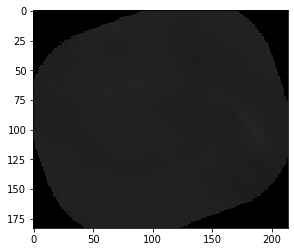

R_LC82330172014297LGN00_B8_PS_Buffer151.png 0.08230617 0.38861674
R_LC82320172017026LGN00_B8_PS_Buffer151.png 0.31694013 0.7647059
R_LC82330172016255LGN00_B8_PS_Buffer151.png 0.101536825 0.4785687
R_LC82330172013342LGN00_B8_PS_Buffer151.png 0.0007848377 0.0060578287


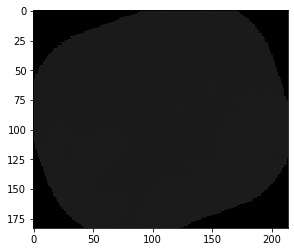

R_LC82320172016296LGN00_B8_PS_Buffer151.png 0.3328583 0.8039216
R_LC82320172014242LGN00_B8_PS_Buffer151.png 0.31471795 0.8156863
R_LC82320172016104LGN00_B8_PS_Buffer151.png 0.19428885 0.7882353
R_LC82320172014130LGN00_B8_PS_Buffer151.png 0.19831833 0.8352941
R_LC82320172015293LGN00_B8_PS_Buffer151.png 0.20977898 0.5803921
R_LC82330172014249LGN00_B8_PS_Buffer151.png 0.10390152 0.4844282
R_LC82330172014137LGN00_B8_PS_Buffer151.png 0.11381369 0.5992676
R_LC82330172015236LGN00_B8_PS_Buffer151.png 0.1114247 0.5151446
R_LC82320172016008LGN00_B8_PS_Buffer151.png 0.112095736 0.36862743
R_LC82320172014258LGN00_B8_PS_Buffer151.png 0.33553734 0.827451
R_LC82320172015021LGN00_B8_PS_Buffer151.png 0.08718243 0.23921567
R_LC82330172016271LGN00_B8_PS_Buffer151.png 0.089209616 0.4408179
R_LC82330172015268LGN00_B8_PS_Buffer151.png 0.08792762 0.41855496
R_LC82320172016312LGN00_B8_PS_Buffer151.png 0.33181712 0.79607844
R_LC82320172014306LGN00_B8_PS_Buffer151.png 0.21990618 0.65098035
R_LC82330172015140LGN

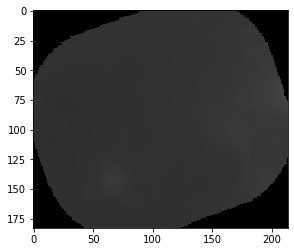

R_LC82330172013246LGN00_B8_PS_Buffer151.png 0.11526622 0.51880676
R_LC82320172014322LGN00_B8_PS_Buffer151.png 0.057465542 0.18039215
R_LC82320172016072LGN00_B8_PS_Buffer151.png 0.245828 0.8117647
R_LC82330172015332LGN00_B8_PS_Buffer151.png 0.034307364 0.20547798


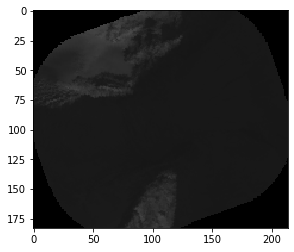

R_LC82330172017001LGN00_B8_PS_Buffer151.png 0.0036817398 0.02151522


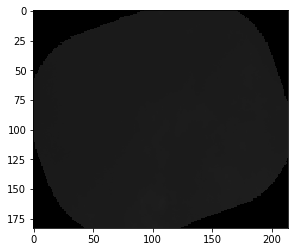

R_LC82330172016303LGN00_B8_PS_Buffer151.png 0.058122195 0.32025635
R_LC82320172015277LGN00_B8_PS_Buffer151.png 0.32982233 0.8117647
R_LC82330172016287LGN00_B8_PS_Buffer151.png 0.08042233 0.4091707
R_LC82320172015197LGN00_B8_PS_Buffer151.png 0.32265475 0.827451
R_LC82330172013294LGN00_B8_PS_Buffer151.png 0.069387786 0.35645074
R_LC82320172015213LGN00_B8_PS_Buffer151.png 0.3335766 0.827451
R_LC82330172014153LGN00_B8_PS_Buffer151.png 0.13634309 0.6061341
R_LC82330172014329LGN00_B8_PS_Buffer151.png 0.031474043 0.16064698


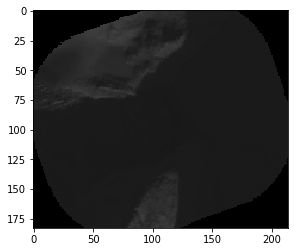

R_LC82320172016328LGN00_B8_PS_Buffer151.png 0.30554277 0.745098
R_LC82320172016280LGN00_B8_PS_Buffer151.png 0.32818353 0.8117647
R_LC82320172014098LGN00_B8_PS_Buffer151.png 0.20811006 0.827451
R_LC82320172014210LGN00_B8_PS_Buffer151.png 0.3390415 0.83137256
R_LC82330172015028LGN00_B8_PS_Buffer151.png 0.06121976 0.28548104
R_LC82320172015341LGN00_B8_PS_Buffer151.png 0.023297086 0.12156862


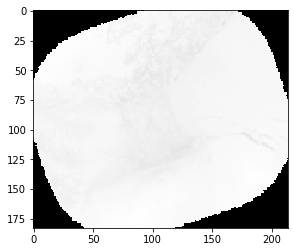

R_LC82320172014066LGN00_B8_PS_Buffer151.png 0.25866163 0.8117647


In [86]:
import cv2

for BoxID in ['151']:
    imagepath = downloadpath+'Box'+BoxID+'/rotated/'
    for img in os.listdir(imagepath):
        if img.endswith('Buffer'+BoxID+'.png'):
            image = cv2.imread(imagepath+img,-1)
            imageplt = mpimg.imread(imagepath+img)
            image_nofill = imageplt[imageplt > 0] # don't consider the fill points
            
            
            img_std = np.std(image_nofill)
            img_range = np.max(image_nofill) - np.min(image_nofill)
            print(img, img_std, img_range)
            
            if img_std < 0.04:
#             if img_range < 1:
                imgplt_trim = plt.imshow(cv2.cvtColor(imageplt, cv2.COLOR_BGR2RGB))
                plt.show()

# 8) Calculate weighted average flow direction for each glacier

The following code processes ice velocity rasters to determine each glacier of interest's weighted average flow direction. The rasters are subset using the terminus box shapefile using a GDAL command (**gdalwarp**) with the following syntax:

    gdalwarp -cutline path_to_terminusbox.shp -crop_to_cutline path_to_input_velocity.TIF path_to_output_velocity_at_term###.TIF

In [141]:
for BoxID in BoxIDs:
    terminus_path = basepath+"Box"+BoxID+"/RGI_Box"+BoxID+".shp"  # set path to RGI shapefiles
    vx = 'greenland_vel_mosaic250_vx_v1.tif';vy = 'greenland_vel_mosaic250_vy_v1.tif' # names of velocity files
    
    if os.path.exists(terminus_path) == False: # if the RGI shapefile does not exist
        terminus_path = basepath+"Box"+BoxID+"/Box"+BoxID+".shp"  # set the path to the box shapefile instead       
        #SET output paths
        vx_out = basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vx; vy_out = basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vy; 
    else:
        #SET output paths
        vx_out = basepath+"Box"+BoxID+"/RGI_Box"+BoxID+'_'+vx; vy_out = basepath+"Box"+BoxID+"/RGI_Box"+BoxID+'_'+vy; 
        
    vx_in = basepath+vx; vy_in = basepath+vy #set input paths
        
    #SET velocity subset commands and print to check it
    v_subset1 = 'gdalwarp -cutline '+terminus_path+' -crop_to_cutline '+vx_in+" "+vx_out
    v_subset2 = 'gdalwarp -cutline '+terminus_path+' -crop_to_cutline '+vy_in+" "+vy_out
#         print(v_subset_dir_cmd); print(v_subset_mag_cmd)

    #SUBSET velocity rasters
    subprocess.call(v_subset1, shell=True)
    subprocess.call(v_subset2, shell=True)
    
    print("Box"+BoxID+' done.')

Box101 done.
Box106 done.
Box111 done.
Box116 done.
Box121 done.
Box126 done.
Box131 done.
Box136 done.
Box146 done.
Box151 done.
Box156 done.
Box161 done.
Box166 done.
Box171 done.
Box176 done.
Box181 done.
Box186 done.
Box191 done.
Box196 done.
Box201 done.
Box206 done.
Box211 done.
Box216 done.
Box221 done.
Box226 done.
Box231 done.
Box236 done.
Box241 done.
Box246 done.
Box251 done.
Box256 done.
Box261 done.
Box266 done.
Box271 done.
Box276 done.
Box281 done.
Box286 done.
Box291 done.
Box296 done.


Next, these subset velocity rasters are opened using the **rasterio** package and read into arrays. They are filtered for anomalous values and the velocity magnitudes are converted into weights. Then the **numpy.average()** function is used to calculated the weighted average flow directions where the flow directions of the pixels where the highest velocities are found are weighted more. 

The resulting average flow direction will be representative of the glacier's main flow. These directions will be used to rotate the images of the glaciers so that their flow is due right.

In [142]:
#CREATE list of glacier average flow directions:
boxes = []; avg_rot = []; max_mag = []; num_cells = []

for BoxID in BoxIDs:
    rot_angles = []; max_magnitudes = []
    
    #READ velocity direction and magnitude data at terminus for each glacier into an array
    vx_name = 'greenland_vel_mosaic250_vx_v1.tif';vy_name = 'greenland_vel_mosaic250_vy_v1.tif'

    rgi_exists = 0
    for file in os.listdir(basepath+"Box"+BoxID):
        if file.startswith('RGI'):
            rgi_exists = 1
    if rgi_exists == 1:      
        vx = rasterio.open(basepath+"Box"+BoxID+"/RGI_Box"+BoxID+'_'+vx_name, "r") # RGI
        vy = rasterio.open(basepath+"Box"+BoxID+"/RGI_Box"+BoxID+'_'+vy_name, "r") # RGI
    else:
        vx = rasterio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vx_name, "r") # box 
        vy = rasterio.open(basepath+"Box"+BoxID+"/Box"+BoxID+'_'+vy_name, "r") # box
         
    vx_array = vx.read(); vy_array = vy.read()
    #remove no data values (-2000000000.0)
    vx_masked = vx_array[vx_array != -2000000000.0]; vy_masked = vy_array[vy_array != -2000000000.0]
        
    #CALCULATE FLOW DIRECTION
    direction = np.arctan2(vy_masked, vx_masked)*180/np.pi; 
#   print(BoxID, direction.max(), direction.min())
    #transform so any negative angles are placed on 0 to 360 scale:
    if len(direction[direction < 0]) > 0:
        direction[direction < 0] = 360.0+direction[direction < 0]
        
    #CALCULATE SPEED
    magnitude = np.sqrt((vx_masked*vx_masked) + (vy_masked*vy_masked)) 
        
    if len(direction) > 0: # if there are velocity values remaining
        # IF THERE ARE DIRECTIONS THAT HAVE A REALLY LARGE RANGE > 250.0 it's probably pointing East
        dir_range = direction.max() - direction.min()
        if dir_range > 200.0 and len(direction[direction >200]): # if large range and values above 200
            direction[direction > 180] = direction[direction > 180] - 360.0 # grab those values on a negative scale
            # CALCULATE the weighted average rotation angle
            # calculate weights (0 - 1) from magnitudes
            mag_range = magnitude.max() - magnitude.min(); stretch = 1/mag_range
            weights = stretch*(magnitude - magnitude.min())
            avg_dir = np.average(direction, weights=weights)
            max_magnitude = magnitude.max()*0.00273973 # conversion to m/d?
#           print("East!", avg_dir)
            if avg_dir < 0:
                avg_dir = avg_dir + 360.0 # transform back to 0 to 360 scale
        else:
            mag_range = magnitude.max() - magnitude.min()
            stretch = 1/mag_range
            weights = stretch*(magnitude - magnitude.min())
            avg_dir = np.average(direction, weights=weights)
    #           print(avg_dir)
            max_magnitude = magnitude.max()*0.00273973 # conversion to m/d?
    else:
        avg_dir = np.NaN ; max_magnitude = np.NaN # no velocities to calculate this with

    #APPEND to lists:
    avg_rot.append(avg_dir); max_mag.append(max_magnitude); boxes.append(BoxID); num_cells.append(len(direction))
        
velocities_df = pd.DataFrame(list(zip(boxes,avg_rot, max_mag, num_cells)), columns=['BoxID','Flow_dir', 'Max_speed', 'Pixels'])
velocities_df = velocities_df.sort_values(by='BoxID')
velocities_df = velocities_df.drop_duplicates()
velocities_df

,BoxID,Flow_dir,Max_speed,Pixels
0,101,84.396744,1.498163,1254
1,106,313.686653,0.558953,653
2,111,54.421913,0.329401,416
3,116,40.674145,0.750883,280
4,121,272.830338,1.441556,1151
5,126,350.325916,0.472128,787
6,131,49.832695,0.444677,967
7,136,30.197475,0.614712,419
8,146,42.575176,0.341090,376
9,151,340.247601,1.056471,424


#### Write glacier velocities to a csv file

In [143]:
VEL_NAME = 'Glacier_vel_measures_SE_2.csv'
velocities_df.to_csv(path_or_buf = basepath+VEL_NAME, sep=',')

# 9) Rotate all images by flow direction

Read in the glacier velocity file as velocities_df if not already loaded:

In [144]:
# velocities_df = pd.read_csv(basepath+'Glacier_vel_measures_SE.csv', sep=',', dtype=str)
# velocities_df = pd.read_csv(basepath+'Glacier_velocities.csv', sep=',', dtype=str, usecols=[1,2,3])
velocities_df = velocities_df.set_index('BoxID')
# velocites_df = velocities_df.dropna()
velocities_df

,Flow_dir,Max_speed,Pixels
BoxID,,,
101,84.396744,1.498163,1254
106,313.686653,0.558953,653
111,54.421913,0.329401,416
116,40.674145,0.750883,280
121,272.830338,1.441556,1151
126,350.325916,0.472128,787
131,49.832695,0.444677,967
136,30.197475,0.614712,419
146,42.575176,0.341090,376


In [145]:
#make directory for rotated images in BoxID folders if it doesn't already exist
for BoxID in BoxIDs:
    if os.path.exists(downloadpath+"Box"+BoxID+'/rotated/'):
        print("Already exists.")
        #OTHERWISE, create the folder and download into it
    else:
        os.mkdir(downloadpath+"Box"+BoxID+'/rotated/')
        print("Folder made for Box"+BoxID)

Folder made for Box101
Folder made for Box106
Folder made for Box111
Folder made for Box116
Folder made for Box121
Folder made for Box126
Folder made for Box131
Folder made for Box136
Folder made for Box146
Folder made for Box151
Folder made for Box156
Folder made for Box161
Folder made for Box166
Folder made for Box171
Folder made for Box176
Folder made for Box181
Folder made for Box186
Already exists.
Already exists.
Folder made for Box201
Folder made for Box206
Folder made for Box211
Folder made for Box216
Folder made for Box221
Folder made for Box226
Folder made for Box231
Folder made for Box236
Folder made for Box241
Folder made for Box246
Folder made for Box251
Folder made for Box256
Folder made for Box261
Folder made for Box266
Folder made for Box271
Folder made for Box276
Folder made for Box281
Folder made for Box286
Folder made for Box291
Folder made for Box296


In [146]:
#move rasterized terminus box into reprojected folder:
for BoxID in BoxIDs:
    boxfile = 'Box'+BoxID+'_raster_cut.TIF'
    boxrasterpath = basepath+'Box'+BoxID+'/'+boxfile
    newpath = downloadpath+'Box'+BoxID+'/reprojected/'+boxfile
    shutil.copyfile(boxrasterpath, newpath)

In [147]:
#convert all files in reprojected folder to png from TIF
for BoxID in BoxIDs:
    command = 'cd '+downloadpath+'Box'+BoxID+'/reprojected/; '+'mogrify -format png *.TIF'
#     print(command)
    subprocess.call(command, shell=True)

In [154]:
#ROTATE THE IMAGES IF VELOCITIES ARE GOOD
for index, row in velocities_df.iterrows():
    BoxID = index
    print(BoxID) 
    #for each file in the reprojected folder:
    for file in os.listdir(downloadpath+"Box"+BoxID+'/reprojected/'):
        if file.endswith('.png'):
            img  = Image.open(downloadpath+"Box"+BoxID+'/reprojected/'+file)
            rotated = img.rotate(-float(row['Flow_dir']))
            rotated.save(downloadpath+"Box"+BoxID+'/rotated/R_'+file)

101
106
111
116
121
126
131
136
146
151
156
161
166
171
176
181
186
191
196
201
206
211
216
221
226
231
236
241
246
251
256
261
266
271
276
281
286
291
296


# 10) Resize all images to the same size (the minimum image size)

In [ ]:
# #Make sure folders are removed
# for BoxID in BOXIDS:
#     if os.path.exists(downloadpath+"Box"+BoxID+'/rotated/'):
#         shutil.rmtree(downloadpath+"Box"+BoxID+'/rotated/', ignore_errors=False, onerror=None)
#     else:
#         print("Resized folder already removed")

In [159]:
for index, row in velocities_df.iterrows():
# for BoxID in ['279']:
    BoxID = index
    print(BoxID)
    dimensions_x = []; dimensions_y = []
    images = os.listdir(downloadpath+"Box"+BoxID+'/rotated/')
    for image in images:
        if image.endswith('.png'):
            img = mpimg.imread(downloadpath+"Box"+BoxID+'/rotated/'+image)
            dimensions_x.append(img.shape[1]); dimensions_y.append(img.shape[0])

    #find minimum dimensions
    min_y = np.min(dimensions_y); min_x = np.min(dimensions_x)
    index_y = dimensions_y.index(min_y); index_x = dimensions_x.index(min_x)
          
    if index_x != index_y:
        print('Something is funky with the image dimesions for Box'+BoxID)
    else:
        crop_y = dimensions_y[index_y]; crop_x = dimensions_x[index_y] # grab image dimensions

        #crop each image if the dimensions are larger than the minimum
        for image in images:
            if image.endswith('.png'):
                img = mpimg.imread(downloadpath+"Box"+BoxID+'/rotated/'+image)
                if img.shape[1] > crop_x or img.shape[0] > crop_y:
                    #calculate difference, and divide by 2 to get amount of rows to remove by
                    diffx_half = (img.shape[1] - crop_x)/2; diffy_half = (img.shape[0] - crop_y)/2

                    #if the difference is a half pixel, make sure to remove the full value from the first side only
                    if int(diffx_half) != diffx_half:
                        #remember for image slicing y is the first dimension, x is the second
                        img_cropx = img[:, int(diffx_half):-int(diffx_half)-1]
                    else: #otherwise remove it from both sides:
                        img_cropx = img[:, int(diffx_half):-int(diffx_half)]

                    #same for y
                    if int(diffy_half) != diffy_half:   
                        img_cropy = img_cropx[int(diffy_half):-int(diffy_half)-1, :]
                    else:
                        img_cropy = img_cropx[int(diffy_half):-int(diffy_half), :]

                    #save over original images
                    plt.imsave(downloadpath+"Box"+BoxID+'/rotated/'+image, img_cropy, cmap='gray')

101
106
111
116
121
126
131
136
146
151
156
161
166
171
176
181
186
191
196
201
206
211
216
221
226
231
236
241
246
251
256
261
266
271
276
281
286
291
296


#### Convert these final images to pgm for Xsmurf analysis:

In [160]:
#convert all final files to pgm
for index, row in velocities_df.iterrows():
# for BoxID in ['279']:
    BoxID = index
    command = 'cd '+downloadpath+'Box'+BoxID+'/rotated/; '+'mogrify -format pgm *.png'
    subprocess.call(command, shell=True)

In [ ]:
# rename the rasterized terminus box files if necessary
for index, row in velocities_df.iterrows():
    BoxID = index
    files = os.listdir(downloadpath+'Box'+BoxID+'/rotated/')
    for file in files:
        if file.startswith('R_Box'+BoxID+'_cut'):
            rpath = downloadpath+'Box'+BoxID+'/rotated/'
            os.rename(rpath+file, rpath+'R_Box'+BoxID+'_raster_cut'+file[-4:])